# Customer Targeting under Response-Dependent Costs

Link to our github repo: https://github.com/aynetdia/APA_multitask_causal_hurdle_NN


In [ ]:
#Import all the necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#define losses that will be used here and also in the future
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error
import pandas as pd
import itertools
import multiprocessing
import random
import math

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

#specify the gpu device used for training
#WARNING: the GPU device affects training reproducibility! (presumably because of floating point precision? fp16 vs fp32)
#we used Tesla T4 all the neural networks (except for the one Residual Model, where it is specified otherwise) and CPU for their evaluation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  ! nvidia-smi
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [ ]:
# Mount on GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Specify path to the apa directory
###### !This needs to be changed if working elsewhere! ##########
dir_path = '/content/drive/My Drive/apa/'
import os
import sys
sys.path.append(dir_path)
from helper_functions import *

In [ ]:
# Function that sets all the necessary seeds to ensure replicability
def set_seed():
  os.environ['PYTHONHASHSEED'] = str(1)
  random.seed(2)
  np.random.seed(3)
  torch.manual_seed(4)
  torch.cuda.manual_seed_all(5)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Table of Contents

1. Introduction
2. Literature Review
3. Description of the Dataset
4. Baseline Models for Comparison
5. Multitask Architectures (Initial, Alternative and Current)
6. Improvements of Initial MT Architectures
7. Baseline Linear Causal Hurdle Model
8. Residual Model
9. Profit Implications
10. Conclusion and Suggestions for Further Research



# 1. Introduction

For a business to perform profitable marketing, targeting the right customer groups or individuals is just as important as offering suitable marketing campaigns. With the developments in data science and the ever-growing impact of digitalization in business, companies have learned to benefit from analytical tools to make their targeting decisions smarter, more efficient and more profitable. Data-driven approaches can deliver insights about important topics such as which customers would most likely react to a marketing campaign or how much more they would be willing to buy as a result.

E-commerce is rapidly becoming more common and preferable, due to the practicality and accessibility it provides, as opposed to traditional retail stores. One main benefit e-commerce brings to the table for marketing decision-makers is that it allows individual customers to be treated in different ways than others. In the example of a customer who regularly checks the price of a pair of sneakers, one can say that she is waiting for the product to go on discount to finally purchase it. In this case, a smart marketing approach would be to give her a discount that is not offered to any other customers than her. This would allow the business to sell its product to this customer, while still offering it at its original price to other customers, who are willing and able to buy at this price. One might say that the availability of the option to target individual customers with different marketing offers makes the marketing decision-making much more complex and difficult to optimize, but it also provides great opportunities to create competitive power in e-commerce with the right analytical approach and advanced data science skills.

This paper contributes to data-driven marketing approaches in e-commerce by developing methods that increase profit from marketing campaigns with the right targeting decisions, while keeping the proposed models relatively simple. The models implemented in this paper follow the Haupt and Lessmann (2020) approach, which involves considering marketing cost as a stochastic variable, since marketing costs are not known at the moment of the targeting decision and must also be estimated based on how the customer reacts to the offer. In order to make the gradient boosting two-model framework introduced by Haupt and Lessmann (2020) simpler and combined in a single model, this paper aims to build a single neural network model that follows the same targeting and cost-estimating approach.

There are two types of costs in marketing campaigns: targeting-dependent variable costs, which arise when the marketing action is taken, regardless of its success, and response-dependent variable costs, which are considered when customer responds positively to the marketing action. Total cost is important in making the targeting decision, since the marketing campaign aims to make profit by providing revenue that is higher than the associated cost, with a decided rate. Since total cost is conditional on the targeting decision and the customer response, it is not known at the point of the targeting decision.

Common approaches to marketing targeting involves estimating conditional average treatment effect (CATE) as implemented by Devriendt et. al. (2018). With this approach, the top k deciles of the sample with the highest estimated CATE are selected as the targeted group and given the marketing offer. Haupt and Lessmann (2020) add response-dependent costs to the equation and suggest estimating treatment effect in relation to teh cost of treatment. In this case, the number of customers to target is based on the revenue-cost ratio, so the profitability ratio is decided by the decision-maker.

This paper consists of two parts: the first is estimating customer conversion and response value, and the other is building a causal hurdle model to estimate treatment effects. For the first part, baseline models with simple architectures are built first for further comparison, multitask neural networks with different approaches are implemented, and additional improvements are made to the multitask nets. For the second part, benchmark causal hurdle two-model approach is again built as a standard for comparison, and then a residual model is built, which is followed by analyzing profit implications as a result of targeting decisions.



# 2. Literature Review

This paper follows the targeting decision approach suggested by Haupt and Lessmann (2020). The first part of their approach, before calculating individual treatment effect, involves estimating probability of customer conversion $p(C=1|X_i)$ and expected checkout amount $E[V|X_i]$. Using the estimations of these targets, expected basket value $E[Y_i]$ is calculated. It is explained by Haupt and Lessmann (2020), that expected basket value is the product of the two outputs, since

$Y_i = C_i*V_i$

In the second part of the task, individual treatment effect is calculated by fitting separate models for the treatment and control groups, and finding the ITE by differencing them using the outputs for the same data samples.

$\tau(X_i)=y(X_i,1)-y(X_i,0)$,

which can be expanded as

$\tau(X_i) = p(C=1|X_i,T=1)*E[V|X_i,T=1] - p(C=1|X_i,T=0)*E[V|X_i,T=0]$

In the final step of the Haupt and Lessmann (2020) approach, profit implications of the output ITE is examined. It is assumed that a marketing campaign is profitable when the revenue obtained is higher than the cost associated with it. Therefore, the different between revenue and cost, which is profit, must be greater than zero. In most cases, the desired profit margin is greater than the breakeven point of having revenue equal to cost, and therefore, a target ROAS is determined by the decision-maker.


$\frac{p_i(1)V_i(1)-p_i(0)V_i(0)}{p_i(1)*\delta+c} \ge Target ROAS$


The numerator is the ITE, which is the additional revenue obtained as a result of the marketing campaign, and the denominator is the total cost. In this case, c is zero, since there is no fixed cost associated with the offer, given that it is given to customers on the retailer's own website without additional fees. $\delta$ is equal to 10, since this is the coupon value. The $p_i(1)*\delta$ unit is the response-dependent cost in this task, since it contains the probability of conversion of the customer, and therefore, cannot be know at the time of the targeting decision, but can be estimated, as done in Part 1. Target ROAS is the target revenue:cost ratio. The decision-maker chooses to target only the customers who are estimated to deliver a higher ROAS than  desired.

Multitask learning aims to solve multiple learning tasks simultaneously, using commonalities and differences between the tasks. This paper makes use of different multitask neural network structures, combining the models involved in the targeting decision as mentioned in Haupt and Lessmann (2020) into a single and more sophisticated model. In addition to adding simplicity and compactness to the overall machine learning task, a multitask neural network architecture provides a more sophisticated approach and more accurate predictions, since it makes use of the relatedness of the different tasks involved in the model. According to Caruana (1997), who compares multitask models to singletask models for three different examples, mutltitask learning generalized 20-30% better, even when compared to the individual outputs of the singletask learning models. There is a synergic effect in the common hidden layers in a multitask neural network model that makes it stronger than different singletask models.

Even though they promise to deliver more accurate results, multitask neural networks tend to have some weaknesses that can decrease their predictive power. In the case when the multiple learning tasks are at different scales, the loss for each task also tends to be at different scales, which leads to one task being prioritized due to higher loss values and the others end up not being learned well enough. In this paper, the two tasks that are aimed to be learned simultaneously are conversion probability and expected checkout amount of customers. Since conversion probability has a range between 0 and 1, while checkout amount is any value equal to or above 0, the scales of the loss values tend to be different and cause imbalance during gradient descent in the training process. In order to avoid one task to be prioritized while the other is ignored, this paper suggests improvements to the multitask models. As suggested by Caruana (1997), using separate learning rates for each of the two tasks and one for the common hidden layers helps the model to learn the two tasks at the same rate. Another approach is to use adaptive dynamic weighting, which according to Liu (2018), instead of adding the loss functions of the two tasks to find the total loss, involves scaling the loss values at each step by the rate of change of loss for each task compared to the loss at the last epoch.



# 3. Description of the Dataset

Haupt and Lessmann (2020) have used a dataset from an online couponing task from a German online fashion retailer. Since this paper is uses their approach to implement a single combined neural network model to do the task, the same dataset is used here as well. The online coupon provides a discount of €10 at checkout to the targeted customers. Since the offer is given at the retailer’s own website, there are no targeting-dependent costs and there are only response-dependent costs, which come into effect once the customer reacts to the offer.

The dataset is composed of 50 variables collected through a tracking software and the shop system, for 118,522 anonymized website visitors. Only 9% of the customers have converted, meaning that they have made a purchase, regardless of whether they are in the treatment or control group.

There is an excessive number of zero values in the dataset. This means that the neural network will have a heavily zero-inflated output. This is because most of customers who check the website do not make a purchase, making the converted customers a minority in the dataset. Since zero-inflated datasets tend to cause computational difficulties and invalidation of distributional assumptions, a hurdle model approach is implemented in Haupt and Lessmann (2020).






In [ ]:
# Import data
X = pd.read_csv(dir_path + "data/fashionB_clean_linear.csv")
c = X.pop('converted')
g = X.pop('TREATMENT')
y = X.pop('checkoutAmount')
tau_conversion = X.pop('TREATMENT_EFFECT_CONVERSION')
tau_basket = X.pop('TREATMENT_EFFECT_BASKET')
tau_response = X.pop('TREATMENT_EFFECT_RESPONSE')

9.563337874888564 % of customers convert


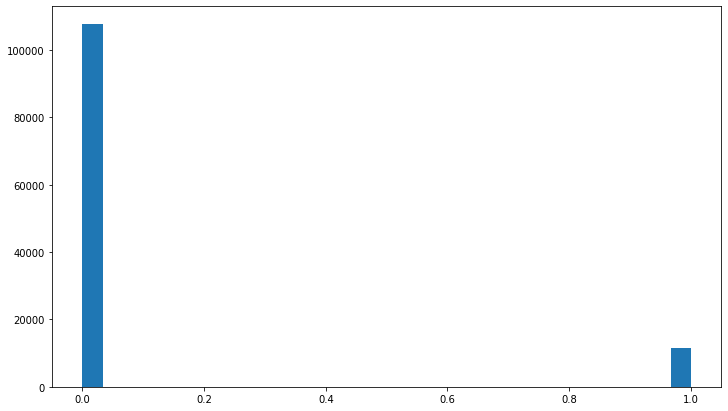

In [179]:
print(100*sum(c)/np.size(c), "% of customers convert")
plt.figure(figsize=(12,7))
plt.show(plt.hist(c, bins=30, range=(0,1)))

The customers who convert make a purchase with a positive value, and those who do not convert do not make a purchase, leading to a checkout amount of zero. Therefore, the distribution of checkout amounts and basket values of the customers are also heavily zero-inflated. The median checkout amount for the customers who convert is calculated as €75.


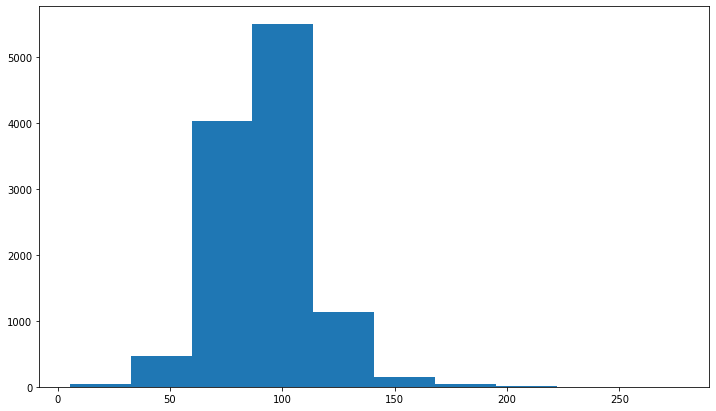

In [180]:
plt.figure(figsize=(12,7))
plt.show(plt.hist(y[c==1]))

In [ ]:
# Split and normalize the data
#stratify on both c and g so that in the future the nn predicting ite is trained on the same data as the one predicting the basket value
(x_train, x_tv, y_train, y_tv, c_train, c_tv, g_train, g_tv, tau_response_train, 
 tau_response_tv, tau_basket_train, tau_basket_tv, tau_conversion_train, 
 tau_conversion_tv) = train_test_split(X, y, c, g, tau_response, tau_basket, 
                                       tau_conversion, train_size=0.7, 
                                       stratify = np.array(c,g), random_state=42)
 
(x_test, x_val, y_test, y_val, c_test, c_val, g_test, g_val, tau_response_test,
 tau_response_val, tau_basket_test, tau_basket_val, tau_conversion_test, 
 tau_conversion_val) = train_test_split(x_tv, y_tv, c_tv, g_tv, tau_response_tv, 
                                       tau_basket_tv, tau_conversion_tv, train_size = 0.5, 
                                       stratify = np.array(c_tv,g_tv), random_state=42)

# Find columns that are not binary with max=1 and standardize it
num_columns = np.where(X.columns[(X.max(axis=0) != 1)])[0].tolist()
ct = ColumnTransformer([("num_preproc", StandardScaler(), num_columns)], remainder="passthrough")
x_train = ct.fit_transform(x_train)
x_val = ct.transform(x_val)
x_test = ct.transform(x_test)

# 4. Baseline Models

The first part consists of estimating the expected basket value for each customer. Before the suggested models in this paper are introduced, it is important to build baseline models for the same task, in order to have a benchmark for further analysis and evaluation of the performance of the suggested models.

A hurdle model is implemented to estimate the expected basket value for each customer. This part does not consider causality and the model does not take into consideration whether a customer is in the treatment or control group at all. The hurdle model consists of two parts: one process for zero counts and another for positive counts. Positive counts occur once a threshold is crossed and the hurdle is cleared. In this case, the first-stage process is used to estimate the probability of customer conversion. Then, only the customers who are estimated to convert are considered in the second-stage process, which estimates the checkout amount for each customer. This means that the customers who do not cross the first stage are not considered in the second-stage process, since not converting means not purchasing any products, while those who cross must have a strictly positive checkout amount, leading to a strictly positive expected basket value.

Different models can be used for the first-stage and second-stage processes. In this project, two baseline hurdle models for the expected basket value are built. The first hurdle model consists of firstly a logistic regression model and then a linear regression model. The second hurdle model is composed of two neural networks, first with a sigmoid output layer and the second with a linear output layer. The outputs of the first- and second-stage models, which are conversion probability and checkout amount, are multiplied to find the expected basket value, for each of the two-part hurdle models, leading to two baseline model outputs for further model evaluation.


# 4.1 Baseline Model 1: Logistic and Linear Regression Models

> First-Stage Process: Logistic Regression for Conversion Probability Estimation

A customer is converted if she makes a purchase, regardless of whether she is treated with the marketing campaign or not. Conversion probability $p(C=1 | X_i)$ is estimated in the first stage of the hurdle model, using logistic regression. The regressors are Xi for each customer. AUC is used as the performance metric for this model and it is measured based on the output for the test data. The estimated conversion probability is compared to the known conversion variable Ci for each customer. It should be noted that the estimated probability is a value between 0 and 1, while Ci only takes the values of 0 and 1, meaning that the customer either does not convert or converts, respectively.


In [ ]:
# Baseline Models (Linear and Logit Models)

# ---- Baseline Model 1: Conversion Logistic Regression

# create and fit a logistic regression model
c_clas = LogisticRegression(solver='liblinear', random_state=42)
c_clas.fit(x_train, c_train)
c_pred = c_clas.predict_proba(x_train)[:,1]
# predict conversion probability on validation data
c_val_pred = c_clas.predict_proba(x_val)[:,1]
c_val_pred_binary = c_clas.predict(x_val)
# predict on test data
c_test_pred_linear = c_clas.predict_proba(x_test)[:,1]
# calcuate performance metric AUC for validation and test predictions
AUC_val = roc_auc_score(c_val, c_val_pred)
AUC_test = roc_auc_score(c_test, c_test_pred_linear)

metric_baseline_log = AUC_test

print(AUC_test)

0.6440224677428446


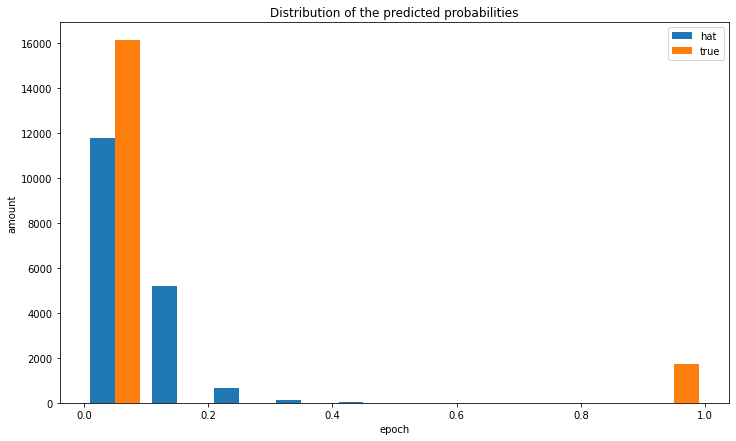

In [178]:
# plot distributions of the actual and predicted conversion probabilities
plt.figure(figsize=(12,7))
plt.hist([c_test_pred_linear, c_test.to_numpy()], label=['hat', 'true'])
plt.legend(loc='upper right')
plt.title('Distribution of the predicted probabilities')
plt.xlabel('epoch')
plt.ylabel('amount')
plt.show()

> Second-Stage Process: Linear Regression for Checkout Value Estimation

The customers who have converted are known to have made a purchase. The checkout value of each converted customer’s purchase is estimated in the second-stage process. First of all, the train dataset is filtered to remove non-converted customers, since the checkout value regression model has to be trained using only the converted customers. Then, the checkout amount is regressed on the customer characteristics matrix X. Since only the converted customers are taken into account, and the basket value is the product of conversion and checkout amount, the checkout amount is actually equal to the basket value for the considered data samples. Therefore, the dependent variable in this model is taken as the basket value Y. The performance metric is mean squared error, calculated between estimated checkout amount E[V I Xi] and the known basket value Yi for each customer. Performance is measured based on the output for the test data.

In [ ]:
# ---- Baseline Model 2: Checkout Value Linear Regression

# filter train dataset to select only converted data samples
x_train_converted = x_train[c_train==1,]
y_train_converted = y_train[c_train==1]

# create and fit a linear regression model
y_regr = LinearRegression()
y_regr.fit(x_train_converted, y_train_converted)
y_pred = y_regr.predict(x_train_converted)
# predict checkout amount on validation and test data
y_val_pred = y_regr.predict(x_val)
y_test_pred = y_regr.predict(x_test)
# calcuate MSE for validation and test predictions
MSE_y_val = mean_squared_error(y_val[c_val==1], y_val_pred[c_val==1])
MSE_y_test = mean_squared_error(y_test[c_test==1], y_test_pred[c_test==1])

metric_baseline_lin = MSE_y_test

print(MSE_y_test)

286.9580153179709


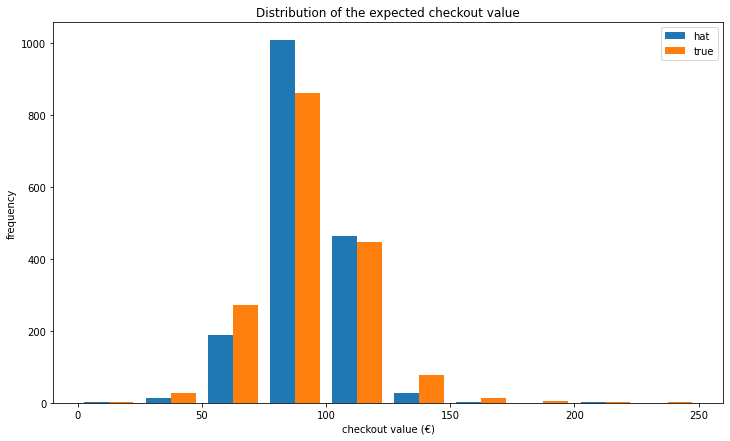

In [177]:
# plot distributions of the actual and predicted checkount amounts, only for converted test data samples
plt.figure(figsize=(12,7))
plt.hist([y_test_pred[c_test==1], y_test[c_test==1]], label=['hat', 'true'], range=[0,250])
plt.legend(loc='upper right')
plt.title('Distribution of the expected checkout value')
plt.xlabel('checkout value (€)')
plt.ylabel('frequency')
plt.show()

> Expected Basket Value Estimation Using the Two Processes

The expected basket value is estimated by multiplying the outputs of the two processes. For this step, the converted customers should not be filtered. All customers, thus all data samples, must be used as inputs to the first-stage and second-stage models, and the outputs should be multiplied. The performance metric is mean squared error and it is measured based on the output for the test data. The expected basket value estimates are compared to the known basket values of the customers.

In [ ]:
# ---- Baseline Model 3: Expected Basket Value Regression

# calculate basket value as the product of conversion and checkout amount
basket_train = y_train
basket_pred = c_pred
basket_pred[c_train==1] = basket_pred[c_train==1]*y_pred
basket_pred[c_train==0] = 0

# calculate actual basket value for validation data
basket_val = y_val
# predict basket value for validation data
basket_val_pred = c_val_pred*y_val_pred

# calculate actual basket value for test data
basket_test = y_test
# predict basket value for test data
basket_test_pred = c_test_pred_linear*y_test_pred

# calcuate MSE for validation and test predictions
MSE_basket_val = mean_squared_error(basket_val, basket_val_pred)
MSE_basket_test = mean_squared_error(basket_test, basket_test_pred)

metric_baseline_loglin_basket = MSE_basket_test

print(MSE_basket_test)

756.6524481446277


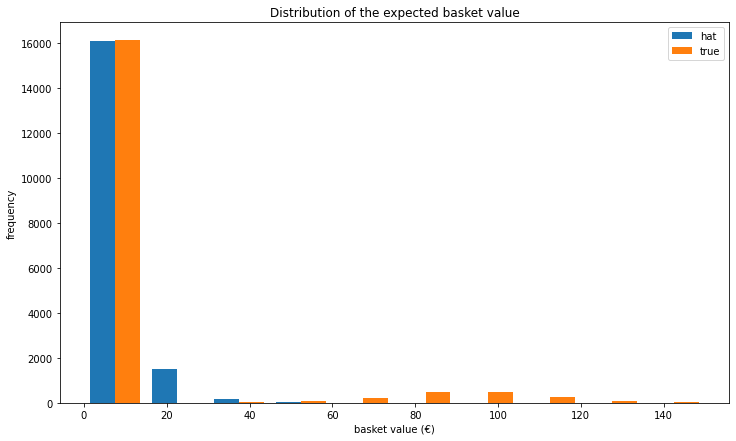

In [176]:
# plot distributions of the actual and predicted basket values for the test data
plt.figure(figsize=(12,7))
plt.hist([basket_test_pred, basket_test], label=['hat', 'true'], range=[0,150])
plt.legend(loc='upper right')
plt.title('Distribution of the expected basket value')
plt.xlabel('basket value (€)')
plt.ylabel('frequency')
plt.show()

# 4.2 Baseline Model 2: Hurdle Model with Neural Networks

In [ ]:
# data prep for baseline NNs
set_seed()

# train baseline NNs on CPU and send data directly to GPU
data_train_base = ExperimentData(torch.from_numpy(x_train).float().to(device), 
                            torch.from_numpy(y_train.values).float().to(device), 
                            torch.from_numpy(c_train.values).float().to(device))

data_train_converted = ExperimentData(torch.from_numpy(x_train[c_train==1]).float().to(device), 
                                      torch.from_numpy(y_train[c_train==1].values).float().to(device), 
                                      torch.from_numpy(c_train[c_train==1].values).float().to(device))

data_val_base = ExperimentData(torch.from_numpy(x_val).float().to(device), 
                          torch.from_numpy(y_val.values).float().to(device), 
                          torch.from_numpy(c_val.values).float().to(device))

data_val_converted = ExperimentData(torch.from_numpy(x_val[c_val==1]).float().to(device), 
                                    torch.from_numpy(y_val[c_val==1].values).float().to(device), 
                                    torch.from_numpy(c_val[c_val==1].values).float().to(device))

# it's more practical to evaluate the models using CPU, rather than GPU, due to Colab's runtime restrictions
data_test_base = ExperimentData(torch.from_numpy(x_test).float(), 
                           torch.from_numpy(y_test.values).float(), 
                           torch.from_numpy(c_test.values).float())

# data loaders for the test set can already be defined here, since the batch size will remain unchanged
test_loader_base = DataLoader(data_test_base, batch_size = len(data_test_base))

> First-Stage Process: Neural Network for Conversion Probability Estimation

Customer conversion probability p(C=1 I Xi) is estimated using a neural network with a single hidden layer. The activation function is ReLU for the hidden layer and sigmoid for the output layer, in order to keep the output value between 0 and 1, since the dependent variable is a probability. Similar to the conversion logistic regression model in Baseline Model 1, the output for each customer is compared to the conversion variable Ci using the AUC performance metric, calculated based on the output for the test data.

In [ ]:
# Baseline Models (NN Models)

# ---- Baseline Model 1: Conversion NN

class ConversionNN(nn.Module):

  def __init__(self, input_dim, hidden_layers, criterion):

    super().__init__()
    
    # define layers of the neural network
    self.hidden_layer_sizes = [input_dim] + hidden_layers
    # define the optimizer for a flexible assignment later
    self.optimizer = None
    # loss criterion assignment
    self.criterion = criterion
    
    # define hidden layer activation function as ReLU
    self.hidden =\
      nn.Sequential(*[nn.Sequential(nn.Linear(input_, output_), nn.ReLU())
      for input_, output_ in
      zip(self.hidden_layer_sizes, self.hidden_layer_sizes[1:])])

    # define output activation as sigmoid
    self.output = nn.Sequential(nn.Linear(self.hidden_layer_sizes[-1], 1), nn.Sigmoid())

  def forward(self, x):
    # forward iteration for neural network
    x = self.hidden(x)
    c = self.output(x)
    return c

  def train_iteration(self, data_loader):
    # one iteration of training on train data
    running_loss = 0.0
    c_pred = []
    c_true = []
    for i, (X,y,c) in enumerate(data_loader):

      c_hat = self(X)
      c_pred.extend(c_hat.squeeze())
      # since the dataset is reshuffled after each epoch, need an array with true values of c
      # for positional consistency with the predicted ones
      c_true.extend(c)
      
      # calculate loss between actual and predicted values, based on chosen criterion
      loss = self.criterion(c_hat.squeeze(), c)
      self.optimizer.zero_grad()   
      # backpropagation     
      loss.backward()
      self.optimizer.step()

      # sum the losses to find running loss
      running_loss += loss.item()

    n_batches = int(np.ceil(len(data_loader.dataset)/data_loader.batch_size))
    # loss per batch
    running_loss = running_loss/n_batches

    # calculate performance metric AUC for calculations
    train_auc = roc_auc_score(torch.Tensor(c_true), torch.Tensor(c_pred))

    return running_loss, train_auc

  def val_iteration(self, data_loader):
    # one iteration for validation on validation data
    val_loss = 0.0
    c_pred_val = []
    c_true_val = []
    with torch.no_grad():
      for i, (X_val,y_val,c_val) in enumerate(data_loader):

        c_hat_val = self(X_val)
        c_pred_val.extend(c_hat_val.squeeze())
        c_true_val.extend(c_val)

        # calculate loss between actual and predicted values, based on chosen criterion
        loss = self.criterion(c_hat_val.squeeze(), c_val)
        val_loss += loss.item()

      # calculate performance metric AUC for calculations
      val_auc = roc_auc_score(torch.Tensor(c_true_val), torch.Tensor(c_pred_val))

    return val_loss, val_auc

  def fit(self, train_loader, epochs, val_loader, path, threshold):
    # fit model using train data and validate on validation data

    val_auc_list = []
    cols = ['epoch', 'train_loss', 'train_auc', 'val_loss', 'val_auc']
    history = pd.DataFrame(columns = cols, index = range(epochs))

    for epoch in range(epochs):
      self.train()
      running_loss, train_auc = self.train_iteration(train_loader)
      self.eval()
      val_loss, val_auc = self.val_iteration(val_loader)

      # print results of each train iteration
      print('[%d] loss: %.4f | validation loss: %.4f | auc: %.4f | val_auc: %.4f' % 
            (epoch+1, running_loss, val_loss, train_auc, val_auc))

      # if validation AUC reached the defined threshold, then stop training and save the model
      if val_auc>threshold:
        if len(val_auc_list)>1 and val_auc>max(val_auc_list):
          torch.save({'model_state_dict': self.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()},
                     dir_path + "simple_nn_tune/%s/model_%s_%s_%.4f_%d_%.4f.tar" % 
                     (path, self.__class__.__name__, self.hidden_layer_sizes[1:], 
                      self.optimizer.param_groups[0]['lr'], epoch+1, val_auc))
      val_auc_list.append(val_auc)
      values = [epoch+1, running_loss, train_auc, val_loss, val_auc]
      history.iloc[epoch] = values

    # save history of training
    history[cols] = history[cols].apply(pd.to_numeric, errors = 'ignore')

    # select iteration number that delivers the maximum validation AUC
    max_val_auc = max(history['val_auc'])
    max_val_auc_epoch = history['epoch'][history['val_auc'].argmax()]

    return max_val_auc, max_val_auc_epoch, history


> Second-Stage Process: Neural Network for Checkout Value Estimation

Checkout values of the converted customers are estimated using a neural network with a single hidden layer. The activation function is ReLU for the hidden layer and linear for the output layer. The performance metric is MSE and calculated based on output for test data.


In [ ]:
# ---- Baseline Model 2: Checkout NN

class CheckoutNN(nn.Module):

  def __init__(self, input_dim, hidden_layers, criterion):

    super().__init__()
    
    # define layers of the neural network
    self.hidden_layer_sizes = [input_dim] + hidden_layers
    self.optimizer = None
    self.criterion = criterion

      # define hidden layer activation function as ReLU
    self.hidden =\
      nn.Sequential(*[nn.Sequential(nn.Linear(input_, output_), nn.ReLU())
      for input_, output_ in
      zip(self.hidden_layer_sizes, self.hidden_layer_sizes[1:])])

    # define output activation as linear
    self.output = nn.Linear(self.hidden_layer_sizes[-1], 1)

  def forward(self, x):
    # forward iteration for neural network
    x = self.hidden(x)
    y = self.output(x)
    return y

  def train_iteration(self, data_loader):
    # one iteration of training on train data
    running_loss = 0.0
    for i, (X,y,c) in enumerate(data_loader):

      y_hat = self(X)
      
      # calculate loss using selected loss criterion
      loss = self.criterion(y_hat.squeeze(), y)

      self.optimizer.zero_grad()     
      # back propagation   
      loss.backward()
      self.optimizer.step()

      # sum the losses to find running loss
      running_loss += loss.item()

    n_batches = int(np.ceil(len(data_loader.dataset)/data_loader.batch_size))
    # loss per batch
    running_loss = running_loss/n_batches

    return running_loss

  def val_iteration(self, data_loader):
    # one iteration of validation on validation dataset
    val_loss = 0.0
    with torch.no_grad():
      for i, (X_val,y_val,c_val) in enumerate(data_loader):

        y_hat_val = self(X_val)
        # calculate loss using selected loss criterion
        loss = self.criterion(y_hat_val.squeeze(), y_val)
        val_loss += loss.item()

    return val_loss

  def fit(self, train_loader, epochs, val_loader, path, threshold):
    # fit model using train data and validate on validation data

    val_loss_list = []
    cols = ['epoch', 'train_loss', 'val_loss']
    history = pd.DataFrame(columns = cols, index = range(epochs))

    for epoch in range(epochs):
      # calculate train and validation loss at each epoch
      self.train()
      running_loss = self.train_iteration(train_loader)
      self.eval()
      val_loss = self.val_iteration(val_loader)

      print('[%d] loss: %.4f | validation loss: %.4f' %
            (epoch+1, running_loss, val_loss))
      
      # if validation loss reached the defined threshold, then stop training and save the model
      if val_loss<threshold:
        if len(val_loss_list)>1 and val_loss<min(val_loss_list):
          torch.save({'model_state_dict': self.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()},
                     dir_path + "simple_nn_tune/%s/model_%s_%s_%.4f_%d_%.4f.tar" % 
                     (path, self.__class__.__name__, self.hidden_layer_sizes[1:], 
                      self.optimizer.param_groups[0]['lr'], epoch+1, val_loss))

      val_loss_list.append(val_loss)
      values = [epoch+1, running_loss, val_loss]
      history.iloc[epoch] = values

    # save history of training
    history[cols] = history[cols].apply(pd.to_numeric, errors = 'ignore')

    # select iteration number that delivers the minimum validation MSE
    min_val_loss = min(history['val_loss'])
    min_val_loss_epoch = history['epoch'][history['val_loss'].argmin()]

    return min_val_loss, min_val_loss_epoch, history

In [ ]:
def simple_nn_tune(net_type, train_data, val_data, criterion, hidden, lr, batch, epochs, path, th):
  # hyperparameter tuning for baseline neural network models

  set_seed()

  # define train and validation data
  train_loader = DataLoader(train_data, batch_size = batch, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = len(val_data))
  res = []

  set_seed()
  # create neural network model using the given hyperparameters
  net = net_type(61, hidden_layers = hidden, criterion = criterion).to(device)
  net.optimizer = optim.Adam(net.parameters(), lr=lr)

  # model fit results
  best_metric_value, best_metric_value_epoch,_ = net.fit(train_loader=train_loader, epochs=epochs, 
                                                         val_loader=val_loader, path=path, threshold=th)
  res.append([net.__class__.__name__, hidden, lr, batch, best_metric_value, best_metric_value_epoch])

  return res

In order to obtain reliable and accurate results using the baseline neural network models, hyperparameter tuning is constructed as the initial step. Different values of hidden layer size, learning rate and batch number are selected and models are fit to different combinations of these values. It is shown below, for which values of the hyperparameters the models have been compared and selected.

In [ ]:
#hide
# values to consider in hyperparameter tuning
param_grid = {'hidden' : [[128], [256], [512]], 'lr' : [0.001, 0.01, 0.1], 'batch' : [128, 256, 512, 1024]}
keys, values = zip(*param_grid.items())
paramlist = list(itertools.product(*values))
set_seed()
grid_sample = random.sample(paramlist, 10)
pd.DataFrame(grid_sample, columns=["hidden layer size", "learning rate", "batch number"])

,hidden layer size,learning rate,batch number
0,[128],0.001,1024
1,[128],0.010,256
2,[512],0.100,512
3,[256],0.100,1024
4,[128],0.100,512
5,[512],0.100,128
6,[512],0.001,256
7,[256],0.100,256
8,[512],0.001,1024
9,[128],0.100,256


In [ ]:
# Training baseline nets
results = []
path = 'conv_nn'

# create conversion neural networks using each hyperparameter combination
for paramset in grid_sample:
  res_conv = simple_nn_tune(ConversionNN, data_train_base, data_val_base, bce_loss, paramset[0], 
                            paramset[1], paramset[2], 75, path, 0.65)
  results.extend(res_conv)

# save results of all models
conv_results = np.array(results)
np.save(dir_path + 'simple_nn_tune/conv_nn_results.npy', conv_results)

print('Baseline NN training completed!')

In [ ]:
checkout_results = []
path = 'checkout_nn'

# create checkout amount neural networks using each hyperparameter combination
for paramset in grid_sample:
  res_checkout = simple_nn_tune(CheckoutNN, data_train_converted, data_val_converted, mse_loss,
                                paramset[0], paramset[1], paramset[2], 300, path, 450)
  checkout_results.extend(res_checkout)

# save results of all models
checkout_results = np.array(checkout_results)
np.save(dir_path + 'simple_nn_tune/checkout_nn_results.npy', checkout_results)

print('Baseline NN training completed!')

Performance metrics based on the validation dataset are shown for the best-performing three conversion probability neural network models:

In [ ]:
# check the results
reg_nn_res = np.load(dir_path + 'simple_nn_tune/checkout_nn_results.npy', allow_pickle=True)
class_nn_res = np.load(dir_path + 'simple_nn_tune/conv_nn_results.npy', allow_pickle=True)

# create data frame to compare models with different hyperparameter value combinations
cols_class = ['type', 'hidden_size', 'lr', 'batch_size', 'max_val_auc', 'max_val_auc_epoch']
cols_reg = ['type', 'hidden_size', 'lr', 'batch_size', 'min_val_loss', 'min_val_loss_epoch']
class_res_framed = pd.DataFrame(class_nn_res, columns = cols_class)
reg_res_framed = pd.DataFrame(reg_nn_res, columns = cols_reg)
class_res_framed[cols_class] = class_res_framed[cols_class].apply(pd.to_numeric, errors = 'ignore')
reg_res_framed[cols_reg] = reg_res_framed[cols_reg].apply(pd.to_numeric, errors = 'ignore')
top_conv_nn = class_res_framed.sort_values(by=['max_val_auc'], ascending=False)
top_checkout_nn = reg_res_framed.sort_values(by=['min_val_loss'], ascending=True)

# display models with hyperparameter combinations that perform best
top_conv_nn.head(3)

,type,hidden_size,lr,batch_size,max_val_auc,max_val_auc_epoch
0,ConversionNN,[128],0.001,1024,0.672180,40
1,ConversionNN,[128],0.010,256,0.664564,16
6,ConversionNN,[512],0.001,256,0.653638,11


Checkout amount neural network model performance results based on the validation dataset for the top five hyperparameter value combinations are shown:

In [ ]:
top_checkout_nn.head(5)

,type,hidden_size,lr,batch_size,min_val_loss,min_val_loss_epoch
4,CheckoutNN,[128],0.100,512,224.757874,213
6,CheckoutNN,[512],0.001,256,243.948410,176
9,CheckoutNN,[128],0.100,256,294.497803,284
8,CheckoutNN,[512],0.001,1024,319.719574,298
7,CheckoutNN,[256],0.100,256,348.936157,294


> Expected Basket Value Estimation Using the Two Processes

The outputs of the two processes, which consist of the neural networks for conversion probability and checkout value, are multiplied to obtain the expected basket value of each customer. Performance is measured based on the output for the test data and the metric is MSE.

Since expected basket value is calculated using the outputs of the conversion probability and checkout amount neural networks, hyperparameter tuning must be operated in a holistic manner. This means that, the combinations of the three best conversion models and five best checkout amount models should be evaluated, to determine how they are combined to deliver accurate predictions for the basket value.

The most accurate basket value estimations are obtained when a checkout neural network with hyperparameters [512, 0.001, 256] and conversion amount neural network with hyperparameters [128, 0.01, 256] are used. These results indicate that the hyperparameter combinations that deliver the best basket value predictions are not necessarily identical to the ones that yield optimum conversion and checkout amount estimations, when considered separately.

In [ ]:
count = 0

# use the top-performing conversion and checkout amount network hyperparameters
# and calculate expected basket value, to determine optimal hyperparameters for it
for conv_params in top_conv_nn.head(3).values:
  for checkout_params in top_checkout_nn.head(3).values:
    count = count+1

    # create conversion neural network
    net1 = ConversionNN(61, conv_params[1], bce_loss)
    state1 = torch.load(dir_path + 'simple_nn_tune/conv_nn/model_ConversionNN_%s_%.4f_%d_%.4f.tar' % 
                        (conv_params[1], conv_params[2], conv_params[5], conv_params[4]), 
                        map_location=torch.device('cpu'))
    net1.load_state_dict(state1['model_state_dict'])

    # create checkout amount neural network
    net2 = CheckoutNN(61, checkout_params[1], mse_loss)
    state2 = torch.load(dir_path + 'simple_nn_tune/checkout_nn/model_CheckoutNN_%s_%.4f_%d_%.4f.tar' % 
                        (checkout_params[1], checkout_params[2], checkout_params[5], checkout_params[4]), 
                        map_location=torch.device('cpu'))
    net2.load_state_dict(state2['model_state_dict'])

    net1.eval()
    net2.eval()
    c_hat_test = net1(data_test_base.X)
    y_hat_test = net2(data_test_base.X)

    # calculate basket value as the product of conversion probability and checkout amount
    basket_value_test_mse = mean_squared_error((y_hat_test*c_hat_test).squeeze().detach().numpy(), data_test_base.y)
    test_auc = roc_auc_score(data_test_base.c, c_hat_test.squeeze().detach().numpy())

    if count==6:
      metric_baseline_nn_conv = roc_auc_score(data_test_base.c, c_hat_test.squeeze().detach().numpy())
      metric_baseline_nn_checkout = mean_squared_error(y_hat_test.squeeze().detach().numpy()[c_test==1], 
                                                 data_test_base.y.squeeze().detach().numpy()[c_test==1])
      basket_baseline_nn_best = (y_hat_test*c_hat_test).squeeze().detach().numpy()
      metric_baseline_nn_basket = basket_value_test_mse
      
    print("Basket Value MSE: ", basket_value_test_mse)
    print("AUC: ", test_auc)

print("--- Evaluation of the best combination hyperparameters:")
print("AUC of Conversion NN on test data: ", metric_baseline_nn_conv)
print("MSE of Checkout NN on test data: ", metric_baseline_nn_checkout)
print("MSE of Basket NN on test data: ", metric_baseline_nn_checkout)

Basket Value MSE:  816.8194
AUC:  0.6433368361534672
Basket Value MSE:  809.5318
AUC:  0.6433368361534672
Basket Value MSE:  801.6607
AUC:  0.6433368361534672
Basket Value MSE:  1138.2124
AUC:  0.6286278459656057
Basket Value MSE:  897.0301
AUC:  0.6286278459656057
Basket Value MSE:  775.1935
AUC:  0.6286278459656057
Basket Value MSE:  970.6022
AUC:  0.633150865493525
Basket Value MSE:  950.8731
AUC:  0.633150865493525
Basket Value MSE:  941.95135
AUC:  0.633150865493525
--- Evaluation of the best combination hyperparameters:
AUC of Conversion NN on test data:  0.6286278459656057
MSE of Checkout NN on test data:  229.45209
MSE of Basket NN on test data:  229.45209


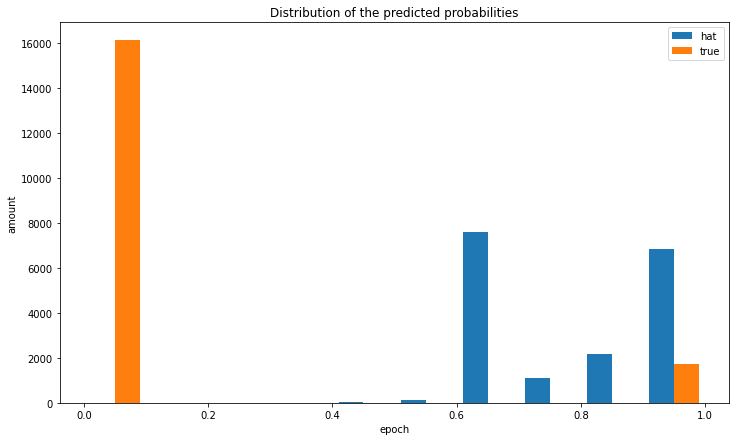

In [175]:
# plot distributions of the actual and predicted conversion probabilities for the test data
plt.figure(figsize=(12,7))
plt.hist([c_hat_test.squeeze().detach().numpy(), c_test.to_numpy()], label=['hat', 'true'])
plt.legend(loc='upper right')
plt.title('Distribution of the predicted probabilities')
plt.xlabel('epoch')
plt.ylabel('amount')
plt.show()

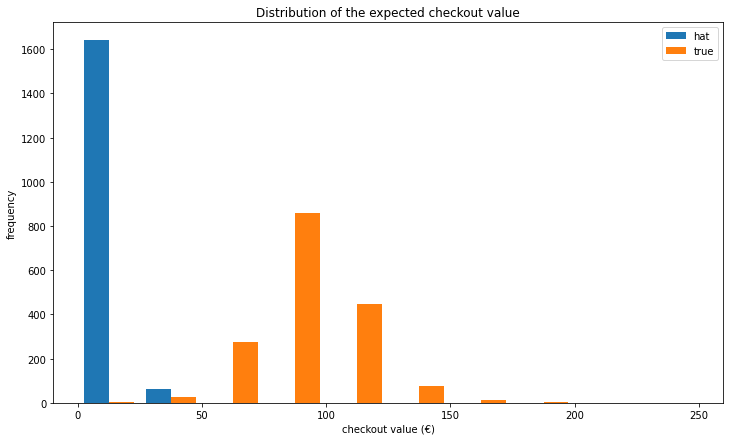

In [174]:
# plot distributions of the actual and predicted checkout amounts for the test data
plt.figure(figsize=(12,7))
plt.hist([y_hat_test.squeeze().detach().numpy()[c_test==1],
          data_test_base.y.squeeze().detach().numpy()[c_test==1]], label=['hat', 'true'], range=[0,250])
plt.legend(loc='upper right')
plt.title('Distribution of the expected checkout value')
plt.xlabel('checkout value (€)')
plt.ylabel('frequency')
plt.show()

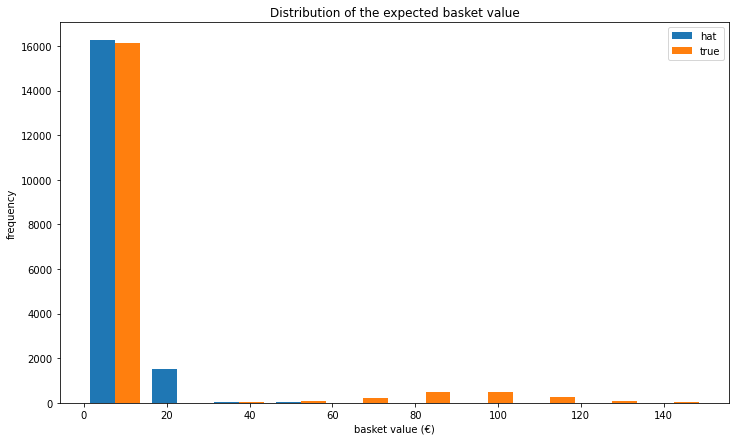

In [173]:
# plot distributions of the actual and predicted basket values for the test data
plt.figure(figsize=(12,7))
plt.hist([basket_baseline_nn_best, y_test], label=['hat', 'true'], range=[0,150])
plt.legend(loc='upper right')
plt.title('Distribution of the expected basket value')
plt.xlabel('basket value (€)')
plt.ylabel('frequency')
plt.show()

As a result, a total of six baseline models are fit, which corresponds to two models per target. The performance metrics and results are displayed and prepared for comparison with the models suggested in this paper in the further steps.

In [172]:
#hide
# create a data frame of performance metrics of all baseline models for further comparison
baseline_eval = pd.DataFrame(["conversion probability", "expected checkout amount", "expected basket value",
                              "conversion probability", "expected checkout amount", "expected basket value"],
                             columns = ["target"])

baseline_eval['model'] = ["logistic regression", "linear regression", "logistic+linear regression",
                          "neural network, sigmoid output", "neural network, linear output", "neural networks"]

baseline_eval['metric_type'] = ["AUC", "MSE", "MSE", "AUC", "MSE", "MSE"]
baseline_eval['metric_result'] = [metric_baseline_log, metric_baseline_lin, metric_baseline_loglin_basket, metric_baseline_nn_conv,
                    metric_baseline_nn_checkout, metric_baseline_nn_basket]

baseline_eval

,target,model,metric_type,metric_result
0,conversion probability,logistic regression,AUC,0.644022
1,expected checkout amount,linear regression,MSE,286.958015
2,expected basket value,logistic+linear regression,MSE,756.652448
3,conversion probability,"neural network, sigmoid output",AUC,0.628628
4,expected checkout amount,"neural network, linear output",MSE,229.452087
5,expected basket value,neural networks,MSE,775.193481


It is observed from the performance metric results of the baseline models, that logistic regression outperforms sigmoid ouput neural network for conversion probability estimation, while the linear output neural network performs better than simple linear regression for expected checkout amount prediction. Since the main target in this task is to estimate expected basket value accurately, it can be concluded from the baseline models that the logistic and linear regression combined model outperforms the two neural networks.

# 5. Multitask Neural Networks

In [ ]:
# data prep for MT nets
set_seed()
# create a weight tensor for weighted BCE
weight = len(c_train[c_train==0])/len(c_train)*10
w = np.ones(len(c_train))
w[c_train==1] = weight

# send data directly to GPU
data_train_mt = WeightedExperimentData(torch.from_numpy(x_train).float().to(device), 
                                    torch.from_numpy(y_train.values).float().to(device), 
                                    torch.from_numpy(c_train.values).float().to(device), 
                                    torch.from_numpy(w).float().to(device))

data_val_mt = ExperimentData(torch.from_numpy(x_val).float().to(device), 
                          torch.from_numpy(y_val.values).float().to(device),
                          torch.from_numpy(c_val.values).float().to(device))

# it's more practical to evaluate the models using CPU, rather than GPU, due to Colab's runtime restrictions
data_test_mt = ExperimentData(torch.from_numpy(x_test).float(), 
                           torch.from_numpy(y_test.values).float(), 
                           torch.from_numpy(c_test.values).float())

val_loader_mt = DataLoader(data_val_mt, batch_size = len(data_val_mt))
test_loader_mt = DataLoader(data_test_mt, batch_size = len(data_test_mt))

After having established our baselines, we proceeded to build the models that are of central interest in our topic. The first neural network architecture that we decided to try out is a pretty straight-forward approach to Multitask Learning (MTL) - it consists of a set of hidden layers that are shared by both tasks, followed by sets of task-specific hidden layers (see figure below). This type of architecture, in which task-specific hidden layers are accompanied by layers shared between tasks, is used quite often in various MTL problems, and one of the examples of that is e.g. the work of Dong et al. (2015). We decided to call this NN architecture *MTNet*.

The main potential pitfall of this architecture that we were warned about before tackling this problem is the difference in the magnitude of the loss values of both tasks. In fact Haupt and Lessmann (2020) initially aimed to include this model architecture in their analysis, however decided to not do it specifically because of this problem. Nevertheless, we wanted to see if we could maybe solve this problem by either finding a better hyperparameter set, or modifying the loss function - more on that further below.

As a side note, we decided to limit the amount of layers in each section of the neural network to 3, in order to keep the size of the network and its training time within reasonable limits, due to constraints in our computational resources. Each hidden layer is activated via ReLU function, which allows for picking up nonlinearities in the training data, and dropout is also applied to each layer in order to prevent overfitting. The output layers utilize the sigmoid activation fucntion when it comes to the classification output, and linear activation function for the regression output. The same applies to other MTL neural network architectures that we used.

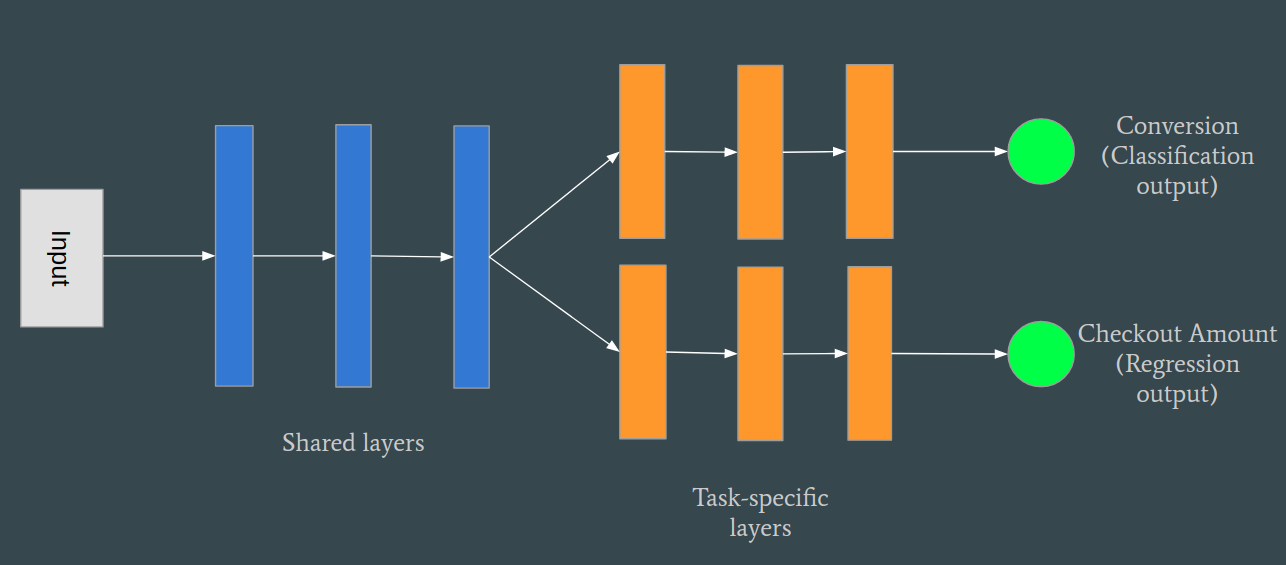

The loss function used in training the *MTNet* is a simple sum of losses of the two tasks, i.e. a sum of the mean squared error (MSE) of the regression task and the binary cross entropy (BCE) of the classification task. Since we were dealing with a zero-inflated dataset, in addition to a simple BCE loss, we decided to try out a weighted BCE loss in the training process of our neural network as well, since lower values of a regular BCE loss do not necessarily indicate a good classification performance when there is a significant imbalance in the dataset. This is the aforementioned modification of the loss function that was not considered by Haupt and Lessmann (2020). More formally, the total loss of the *MTNet* can be defined as:

\begin{equation}
L(\theta_y, \theta_c)=MSE(y, f(x; \theta_y)) + wBCE(c, f(x; \theta_c)),
\end{equation}

where $\theta_y$ and $\theta_c$ are network parameters corresponding to the regression and classification tasks respectively, $y$ and $c$ are regression and classification targets respectively, and $w$ is a weight parameter assigned to each observation, according to its class membership with respect to the *conversion* variable in the dataset, in case the weighted BCE loss is used. Otherwise the weight parameter is just equal to 1 for all observations, i.e. the regular BCE loss is used.


In [ ]:
class MTNetBase(nn.Module):

  def __init__(self, input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted):
    super().__init__()
    
    self.joint_layer_size = joint_layer_size
    self.joint_layer_sizes = [input_dim] + [joint_layer_size, joint_layer_size, joint_layer_size]
    self.disjoint_layer_size = disjoint_layer_size
    self.disjoint_layer_sizes = [joint_layer_size] + [disjoint_layer_size, disjoint_layer_size, disjoint_layer_size]
    self.drop = drop
    self.optimizer = None
    self.criterion_y = criterion_y
    self.criterion_c = criterion_c
    self.weighted = weighted

    self.joint =\
      nn.Sequential(*[nn.Sequential(nn.Linear(input_, output_), nn.ReLU(), nn.Dropout(drop))
      for input_, output_ in
      zip(self.joint_layer_sizes, self.joint_layer_sizes[1:])])

    self.disjoint_c =\
      nn.Sequential(*[nn.Sequential(nn.Linear(input_, output_), nn.ReLU(), nn.Dropout(drop))
      for input_, output_ in
      zip(self.disjoint_layer_sizes, self.disjoint_layer_sizes[1:])])

    self.disjoint_r =\
      nn.Sequential(*[nn.Sequential(nn.Linear(input_, output_), nn.ReLU(), nn.Dropout(drop))
      for input_, output_ in
      zip(self.disjoint_layer_sizes, self.disjoint_layer_sizes[1:])])

    self.output_c = nn.Sequential(nn.Linear(self.disjoint_layer_sizes[-1], 1), nn.Sigmoid())
    self.output_r = nn.Linear(self.disjoint_layer_sizes[-1], 1)

  def forward(self, x):
    
    x = self.joint(x)
    c = self.disjoint_c(x)
    y = self.disjoint_r(x)
    c = self.output_c(c)
    y = self.output_r(y)

    return c,y

In [ ]:
# Inheriting from a class that was used for display purposes for the blogpost format
class MTNet(MTNetBase):

  def __init__(self, input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted):
    super().__init__(input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted)

  def train_iteration(self, data_loader):
    running_loss = 0.0
    train_loss_mse = 0.0
    train_loss_bce = 0.0
    basket_value_train_mse = 0.0
    c_pred = []
    c_true = []
    for i, (X,y,c,w) in enumerate(data_loader):

      pred = self(X)
      c_hat, y_hat = pred[0], pred[1]
      c_pred.extend(c_hat.squeeze())
      #since the dataset is reshuffled after each epoch, need an array with true values of c
      #for positional consistency with the predicted ones, in order to correctly calculate AUROC
      c_true.extend(c)
      
      loss1 = self.criterion_y(y_hat.squeeze(), y)

      if self.weighted == True:
        weighted_criterion = nn.BCELoss(weight = w)
        loss2 = weighted_criterion(c_hat.squeeze(), c)
      else:
        loss2 = self.criterion_c(c_hat.squeeze(), c)
      
      loss3 = self.criterion_y((y_hat*c_hat).squeeze(), y)
      loss = loss1 + loss2

      self.optimizer.zero_grad()        
      loss.backward()
      self.optimizer.step()

      running_loss += loss.item()
      train_loss_mse += loss1.item()
      train_loss_bce += loss2.item()
      basket_value_train_mse += loss3.item()

    n_batches = int(np.ceil(len(data_loader.dataset)/data_loader.batch_size))
    running_loss = running_loss/n_batches
    basket_value_train_mse = basket_value_train_mse/n_batches
    train_loss_mse = train_loss_mse/n_batches
    train_loss_bce = train_loss_bce/n_batches

    train_auc = roc_auc_score(torch.Tensor(c_true), torch.Tensor(c_pred))

    # clunky workaround to avoid rewriting the whole train_iteration for MTXNet
    if 'MTXNet' in self.__class__.__name__:
      basket_value_train_mse = train_loss_mse

    return running_loss, train_auc, train_loss_mse, train_loss_bce, basket_value_train_mse

  def val_iteration(self, data_loader):
    val_loss = 0.0
    val_loss_mse = 0.0
    val_loss_bce = 0.0
    basket_value_val_mse = 0.0
    c_pred_val = []
    c_true_val = []
    with torch.no_grad():
      for i, (X_val,y_val,c_val) in enumerate(data_loader):

        pred_val = self(X_val)
        c_hat_val, y_hat_val = pred_val[0], pred_val[1]
        c_pred_val.extend(c_hat_val.squeeze())
        #here not really needed, since we use the full bacth for validation, but is kept for consistency
        #batching can be required during validation when we are dealing with huge datasets 
        c_true_val.extend(c_val)
        loss1 = self.criterion_y(y_hat_val.squeeze(), y_val)
        loss2 = self.criterion_c(c_hat_val.squeeze(), c_val)
        loss3 = self.criterion_y((y_hat_val*c_hat_val).squeeze(), y_val)
        loss = loss1 + loss2
        val_loss += loss.item()
        val_loss_mse += loss1.item()
        val_loss_bce += loss2.item()
        basket_value_val_mse += loss3.item()

      val_auc = roc_auc_score(torch.Tensor(c_true_val), torch.Tensor(c_pred_val))

      if 'MTXNet' in self.__class__.__name__:
        basket_value_val_mse = val_loss_mse

    return val_loss, val_auc, val_loss_mse, val_loss_bce, basket_value_val_mse

Next architecture that we implemented is a simple modification of the *MTNet*, with an only difference being that the last task-specific hidden layers, before the output layers, are concatenated. The idea behind it was to utilize the inductive transfer of MTL even more by bringing back together the learned task-specific hidden representations of the relationships between the variables right before predicting the targets. Since our two targets are in direct relationship between one another - customers spend a positive amount of money only if they have converted, we hyopthesized that this minor tweak in the architecture might results in some additional improvements. We decided to name the resulting architecture *MTCat*.

As a part of our literature research, we couldn't find any other work that implements the same model architecture tweak.

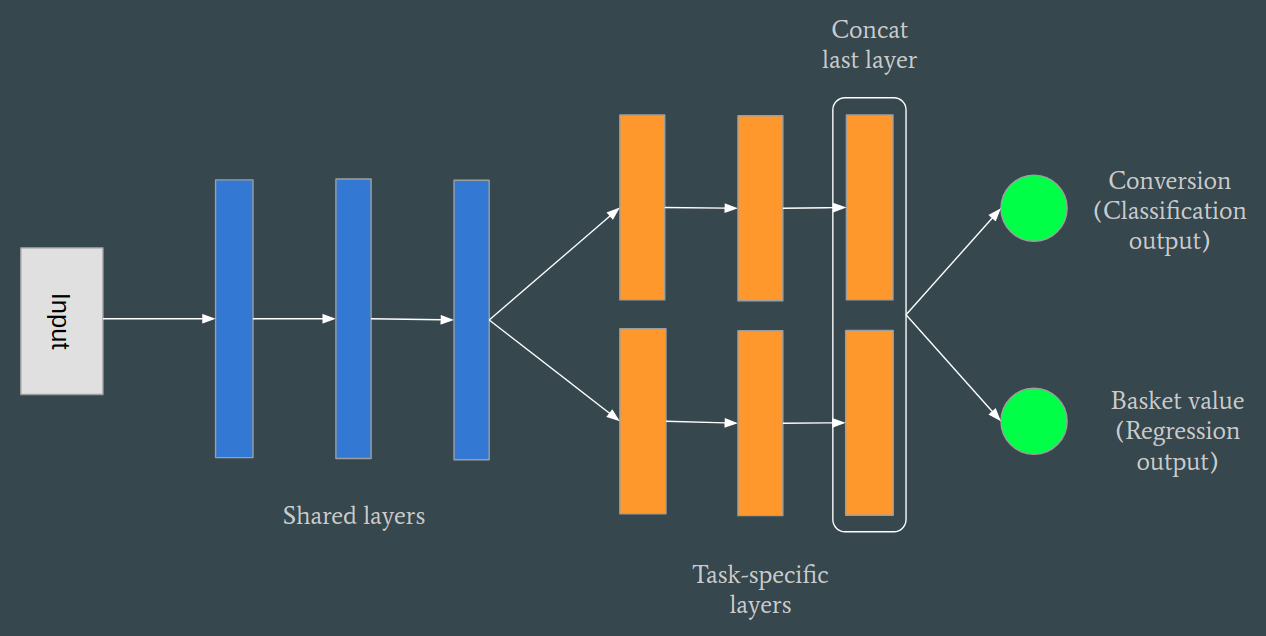

In [ ]:
class MTCat(MTNet):

  def __init__(self, input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted):
    
    super().__init__(input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted)

    self.output_c = nn.Sequential(nn.Linear(self.disjoint_layer_sizes[-1]*2, 1), nn.Sigmoid())
    self.output_r = nn.Linear(self.disjoint_layer_sizes[-1]*2, 1)

  def forward(self, x):
  
    x = self.joint(x)
    c = self.disjoint_c(x)
    y = self.disjoint_r(x)
    cat = torch.cat((c, y), 1)
    c = self.output_c(cat)
    y = self.output_r(cat)

    return c,y

The last approach for a simultaneous regression and classification using neural networks was inspired by Ma et al. (2018). They proposed a loss function that pinpionts the hurdle nature of our task much better. Adapting it to our setting, we get:

\begin{equation}
L(\theta_y, \theta_c) = MSE(y \times c, f(x; \theta_y) \times f(x; \theta_c)) + wBCE(c, f(x; \theta_c))
\end{equation}

As one can see, instead of optimizing network parameters simply for the *checkoutAmount* predictions, the direct connection between the variables *checkoutAmount* and *conversion* is specified explicitly in this loss function. When building models to determine the best targeting strategy of the customers that would yield the most profit, the main estimate of interest is the expected basket value, i.e. *conversion * checkoutAmount*, anyway. Hence taking into account this estimate directly into the loss function sounds very promising. This model architecture will be referred to as *MTXNet* further.

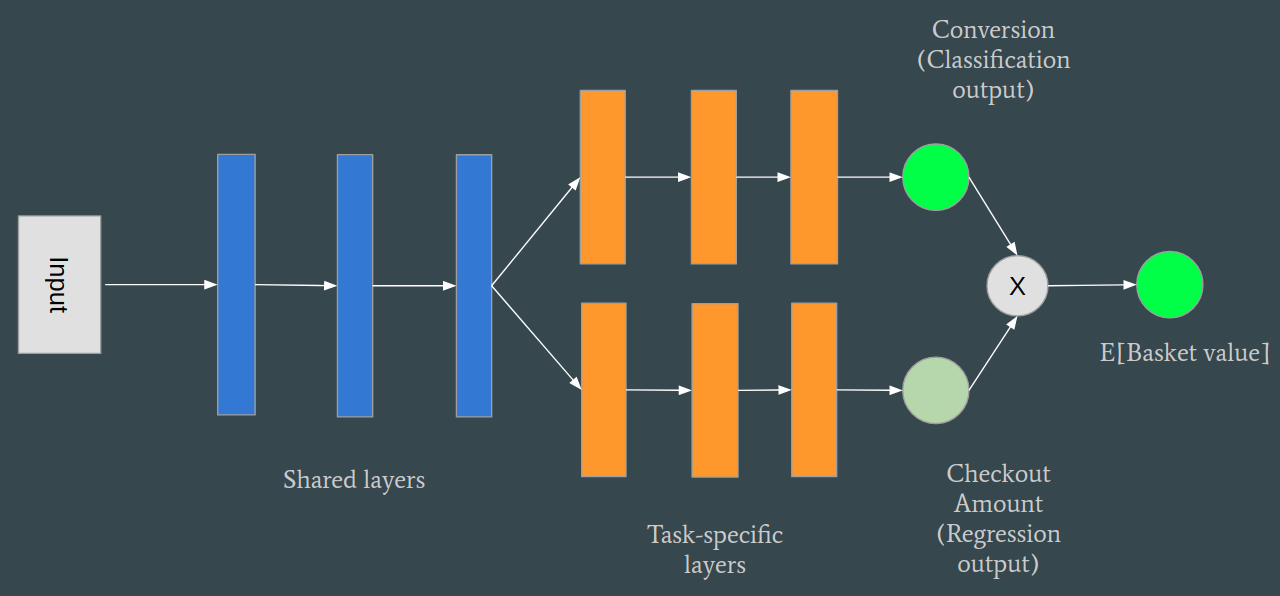

In [ ]:
class MTXNet(MTNet):

  def __init__(self, input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted):

    super().__init__(input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted)

  def forward(self, x):
    
    x = self.joint(x)
    c = self.disjoint_c(x)
    y = self.disjoint_r(x)
    c = self.output_c(c)
    y = self.output_r(y)
    cy = c*y

    return c,cy,y

In [ ]:
def fit_mt(model, path, train_loader, epochs, val_loader):
  #auc and loss lists necessary for tracking performance
  val_auc_list = []
  val_bv_loss_list = []
  #instantiating a data frame that saves history
  cols = ['epoch', 'train_loss', 'basket_value_train_loss', 'train_auc', 'train_mse', 'train_bce', 
          'val_loss', 'basket_value_val_loss', 'val_auc', 'val_mse', 'val_bce']
  history = pd.DataFrame(columns = cols, index = range(epochs))
  for epoch in range(epochs):
    #set the model into training mode - dropout ON
    model.train()
    running_loss, train_auc, train_mse, train_bce, train_bv_loss = model.train_iteration(train_loader)
    #set the model into evaluation mode - dropout OFF
    model.eval()
    val_loss, val_auc, val_mse, val_bce, val_bv_loss = model.val_iteration(val_loader)
    #print out training information
    print('[%d] loss: %.4f | bv train loss: %.4f | validation loss: %.4f | bv val loss: %.4f | auc: %.4f | val auc: %.4f' % 
          (epoch+1, running_loss, train_bv_loss, val_loss, val_bv_loss, train_auc, val_auc))
    #checkpoints
    if (epoch+1)%25 == 0:
      torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': model.optimizer.state_dict()},
              dir_path + "%s/ckpt/ckpt_%s_%s_epoch%d_%d_%d_%.1f_%.4f_%.4f_%.4f.tar" % 
              (path, model.__class__.__name__, model.weighted, epoch+1, model.joint_layer_size, 
               model.disjoint_layer_size, model.drop, val_auc, val_loss, val_bv_loss))
    #save good performing models
    if val_auc>0.64:
      if len(val_auc_list)>1 and val_auc>max(val_auc_list):
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': model.optimizer.state_dict()},
            "/content/drive/My Drive/%s/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar" % 
            (path, model.__class__.__name__, model.weighted, model.joint_layer_size, model.disjoint_layer_size, 
             model.drop, epoch+1, val_auc, val_loss, val_bv_loss))
    #also add saving based on bv loss
    if val_bv_loss<771:
      if len(val_bv_loss_list)>1 and val_bv_loss<min(val_bv_loss_list):
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': model.optimizer.state_dict()},
            dir_path + "%s/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar" % 
            (path, model.__class__.__name__, model.weighted, model.joint_layer_size, model.disjoint_layer_size,
             model.drop, epoch+1, val_auc, val_loss, val_bv_loss))
    val_auc_list.append(val_auc)
    val_bv_loss_list.append(val_bv_loss)
    values = [epoch+1, running_loss, train_bv_loss, train_auc, train_mse, train_bce, val_loss, 
              val_bv_loss, val_auc, val_mse, val_bce]
    history.iloc[epoch] = values
    #'early stopping'
    if len(val_auc_list)>9 and all(i < 0.52 for i in val_auc_list[-9:]):
      break

  # Fill the history data frame and prepare all the necessary variables for the output
  history[cols] = history[cols].apply(pd.to_numeric, errors = 'ignore')

  max_auc = max(history['val_auc'])
  max_auc_loss = history['val_loss'][history['val_auc'].argmax()]
  max_auc_epoch = history['epoch'][history['val_auc'].argmax()]
  max_auc_bv_loss = history['basket_value_val_loss'][history['val_auc'].argmax()]

  min_val_bv_loss = min(history['basket_value_val_loss'])
  min_val_bv_epoch = history['epoch'][history['basket_value_val_loss'].argmin()]
  min_val_bv_auc = history['val_auc'][history['basket_value_val_loss'].argmin()]
  min_val_bv_yloss = history['val_loss'][history['basket_value_val_loss'].argmin()]

  return (max_auc, max_auc_loss, max_auc_epoch, max_auc_bv_loss, min_val_bv_loss, 
          min_val_bv_epoch, min_val_bv_auc, min_val_bv_yloss, history)

# 5.2 Hyperparameter Tuning

In [ ]:
def hyperparam_tune(model_type, joint_dim, disjoint_dim, lr, batch, drop, path):

  set_seed()
  train_loader = DataLoader(data_train_mt, batch_size = batch, shuffle = True)
  epochs = 200
  res = []

  set_seed()
  net = model_type(61, joint_dim, disjoint_dim, mse_loss, bce_loss, drop, weighted = False).to(device)
  net.optimizer = optim.Adam(net.parameters(), lr=lr)

  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss, 
  net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss, net_history) = fit_mt(path = path, model = net, 
                                                                             train_loader = train_loader, 
                                                                             epochs = epochs, 
                                                                             val_loader = val_loader_mt)
  
  net_history.to_csv(dir_path + 'hyperparam_tune2/training_history/%s_%s/%d_%d_%.4f_%d_%.1f.csv' % 
                     (net.__class__.__name__, net.weighted, joint_dim, disjoint_dim, lr, batch, drop))
  res.append([net.__class__.__name__, net.weighted, joint_dim, disjoint_dim, lr, batch, drop, 
              net_max_auc_epoch, net_max_auc, net_max_auc_loss, net_max_auc_bv_loss, net_min_bv_loss,
              net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss])

  set_seed()
  wnet = model_type(61, joint_dim, disjoint_dim, mse_loss, bce_loss, drop, weighted = True).to(device)
  wnet.optimizer = optim.Adam(wnet.parameters(), lr=lr)
  (wnet_max_auc, wnet_max_auc_loss, wnet_max_auc_epoch, wnet_max_auc_bv_loss, wnet_min_bv_loss, 
  wnet_min_bv_epoch, wnet_min_bv_auc, wnet_min_bv_total_loss, wnet_history) = fit_mt(path = path, model = wnet, 
                                                                                  train_loader = train_loader, 
                                                                                  epochs = epochs, 
                                                                                  val_loader = val_loader_mt)
  
  wnet_history.to_csv(dir_path + 'hyperparam_tune2/training_history/%s_%s/%d_%d_%.4f_%d_%.1f.csv' % 
                      (wnet.__class__.__name__, wnet.weighted, joint_dim, disjoint_dim, lr, batch, drop))
  res.append([wnet.__class__.__name__, wnet.weighted, joint_dim, disjoint_dim, lr, batch, drop, 
              wnet_max_auc_epoch, wnet_max_auc, wnet_max_auc_loss, wnet_max_auc_bv_loss, wnet_min_bv_loss, 
              wnet_min_bv_epoch, wnet_min_bv_auc, wnet_min_bv_total_loss])

  return res

Finding optimal hyperparameters for neural networks is crucial to achieving best possible predictions. Therefore we organized a random hyperparameter search with 20 different hyperparameter combinations. Each hyperparameter combination was tested on each multitask architecture introduced previousy in two different variations: with a weighted BCE loss term, and with a regular BCE loss term in each respective loss function. This way we were trying to play safe with regards to having a noticeable imbalance in the target binary variable, i.e. we could determine whether the loss term, corresponding to the binary target class, affects the predictive performance of a multitask hurdle network in any significant way, when training on a zero-inflated data.

In total, 120 models were trained for 200, utilizing the Adam optimization algorithm and mini batching. An aggressive early stopping with regards to a model scoring very low ROC-AUC values or too high basket value MSE values is employed.

In [ ]:
param_grid = {'joint_dim' : [128, 256, 512], 'disjoint_dim' : [64, 128, 256], 
              'lr' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'batch_size' : [128, 256, 512, 1024],
              'dropout' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
keys, values = zip(*param_grid.items())
paramlist = list(itertools.product(*values))
set_seed()
grid_sample = random.sample(paramlist, 20)
grid_sample

[(128, 64, 0.1, 256, 0.7),
 (128, 128, 0.005, 256, 0.7),
 (128, 128, 0.001, 512, 0.6),
 (256, 256, 0.1, 128, 0.3),
 (128, 256, 0.05, 128, 0.9),
 (256, 256, 0.0001, 128, 0.3),
 (256, 128, 0.0001, 512, 0.5),
 (256, 64, 0.005, 128, 0.6),
 (128, 64, 0.01, 128, 0.3),
 (128, 256, 0.01, 128, 0.1),
 (512, 128, 0.0001, 128, 0.1),
 (512, 64, 0.001, 1024, 0.1),
 (512, 256, 0.0005, 1024, 0.7),
 (512, 64, 0.0001, 256, 0.3),
 (512, 256, 0.05, 1024, 0.6),
 (512, 128, 0.0005, 512, 0.5),
 (512, 256, 0.0005, 128, 0.5),
 (256, 128, 0.001, 512, 0.1),
 (128, 64, 0.01, 128, 0.4),
 (128, 64, 0.005, 128, 0.5)]

A combination of AUC and the MSE of an expected basket value were chosen as indicators for determining the predictive performance of all MTL model architecture. Before carrying out the hyperparameter tuning, we hypothesized that a higher AUC would translate into a lower expected basket value MSE. Unfortunately it turned out that this hypothesis was wrong.

In [ ]:
# Training MTNet
results = []
for paramset in grid_sample:
  paramset_result = hyperparam_tune(MTNet, paramset[0], paramset[1], paramset[2], paramset[3], 
                                    paramset[4], path = 'hyperparam_tune2')
  results.extend(paramset_result)

results = np.array(results)
np.save(path_dir + 'hyperparam_tune/tune_results_MTNet.npy', results)
print('MTNet training completed!')

In [ ]:
# Training MTXNet
results = []
for paramset in grid_sample:
  paramset_result = hyperparam_tune(MTXNet, paramset[0], paramset[1], paramset[2], paramset[3],
                                    paramset[4], path = 'hyperparam_tune2')
  results.extend(paramset_result)

results = np.array(results)
np.save(path_dir + 'hyperparam_tune/tune_results_MTXNet.npy', results)
print('MTXNet training completed!')

In [ ]:
# Training MTCat
results = []
for paramset in grid_sample:
  paramset_result = hyperparam_tune(MTCat, paramset[0], paramset[1], paramset[2], paramset[3], 
                                    paramset[4], path = 'hyperparam_tune2')
  results.extend(paramset_result)

results = np.array(results)
np.save(dir_path + 'hyperparam_tune/tune_results_MTCat.npy', results)
print('MTCat training completed!')

In [ ]:
# Pull the summary together
mtnet_res = np.load(dir_path + 'hyperparam_tune2/tune_results_MTNet.npy')
mtxnet_res = np.load(dir_path + 'hyperparam_tune2/tune_results_MTXNet.npy')
mtcat_res = np.load(dir_path + 'hyperparam_tune2/tune_results_MTCat.npy')
res = np.concatenate((mtnet_res, mtxnet_res, mtcat_res), axis = 0)

res_reshaped = res.reshape(-1, 15)
cols = ['type', 'weighted', 'joint_dim', 'disjoint_dim', 'lr', 'batch_size', 'dropout', 'max_val_auc_epoch', 
        'max_val_auc', 'max_val_auc_loss', 'max_val_auc_bv_loss', 'min_bv_loss', 'min_bv_loss_epoch', 
        'min_bv_loss_auc', 'min_bv_total_loss']
res_framed = pd.DataFrame(res_reshaped, columns = cols)
res_framed[cols] = res_framed[cols].apply(pd.to_numeric, errors = 'ignore')
res_framed = res_framed.astype({"max_val_auc_epoch": int, "min_bv_loss_epoch": int})
top_results_auc = res_framed.sort_values(by=['max_val_auc'], ascending=False).head(10).copy()
top_results_auc

,type,weighted,joint_dim,disjoint_dim,lr,batch_size,dropout,max_val_auc_epoch,max_val_auc,max_val_auc_loss,max_val_auc_bv_loss,min_bv_loss,min_bv_loss_epoch,min_bv_loss_auc,min_bv_total_loss
71,MTXNet,True,512,128,0.0005,512,0.5,81,0.667061,762.634155,761.113586,756.272705,91,0.666466,757.845520
91,MTCat,True,256,256,0.0001,128,0.3,103,0.666149,752.381409,770.652771,767.753906,101,0.662428,753.611938
111,MTCat,True,512,128,0.0005,512,0.5,133,0.665150,758.120300,781.949158,774.254211,68,0.649935,754.000427
107,MTCat,True,512,64,0.0001,256,0.3,118,0.665136,753.738647,773.906616,773.906616,118,0.665136,753.738647
27,MTNet,True,512,64,0.0001,256,0.3,135,0.664337,759.841675,791.842773,779.757202,168,0.663690,753.690552
115,MTCat,True,256,128,0.0010,512,0.1,42,0.663366,756.038147,759.559448,759.559448,42,0.663366,756.038147
34,MTNet,False,256,128,0.0010,512,0.1,35,0.663156,762.835999,817.043579,817.043579,35,0.663156,762.835999
11,MTNet,True,256,256,0.0001,128,0.3,92,0.662998,751.172119,773.379333,773.379333,92,0.662998,751.172119
31,MTNet,True,512,128,0.0005,512,0.5,120,0.662534,758.082458,791.974548,786.307678,119,0.661080,755.024719
10,MTNet,False,256,256,0.0001,128,0.3,90,0.662184,753.637085,830.965210,829.580994,144,0.658191,755.248535


In [ ]:
top_results_bv = res_framed.sort_values(by=['min_bv_loss'], ascending=True).head(10).copy()
top_results_bv

,type,weighted,joint_dim,disjoint_dim,lr,batch_size,dropout,max_val_auc_epoch,max_val_auc,max_val_auc_loss,max_val_auc_bv_loss,min_bv_loss,min_bv_loss_epoch,min_bv_loss_auc,min_bv_total_loss
50,MTXNet,False,256,256,0.0001,128,0.3,11,0.651280,840.895020,838.354919,750.664795,104,0.578805,751.692078
74,MTXNet,False,256,128,0.0010,512,0.1,3,0.626926,788.556702,785.201843,751.050598,29,0.497002,751.854736
51,MTXNet,True,256,256,0.0001,128,0.3,159,0.649477,756.998718,755.511414,751.170532,127,0.627772,752.430298
67,MTXNet,True,512,64,0.0001,256,0.3,168,0.657187,758.616821,757.503906,753.596802,133,0.648733,754.952942
61,MTXNet,True,512,128,0.0001,128,0.1,2,0.584586,795.263916,793.317444,754.231750,30,0.494835,754.939087
66,MTXNet,False,512,64,0.0001,256,0.3,18,0.648436,782.563660,780.263306,755.239380,133,0.628211,756.417908
71,MTXNet,True,512,128,0.0005,512,0.5,81,0.667061,762.634155,761.113586,756.272705,91,0.666466,757.845520
75,MTXNet,True,256,128,0.0010,512,0.1,10,0.642023,777.287598,775.252441,757.387878,33,0.611236,759.363281
63,MTXNet,True,512,64,0.0010,1024,0.1,9,0.652555,794.261963,791.889893,758.577637,31,0.604281,760.620605
62,MTXNet,False,512,64,0.0010,1024,0.1,12,0.644827,779.605591,776.541504,758.949890,24,0.593350,761.271484


# 5.3 Model Evaluation

In [ ]:
def evaluate(model, data_loader):
  test_loss = 0.0
  basket_value_test_mse = 0.0
  test_loss_mse = 0.0
  c_pred_test = []
  c_true_test = []
  y_pred_test = []
  with torch.no_grad():
    for i, (X_test,y_test,c_test) in enumerate(data_loader):

      pred = model(X_test)
      c_hat_test, y_hat_test = pred[0], pred[1]
      c_pred_test.extend(c_hat_test.squeeze())
      c_true_test.extend(c_test)
      loss1 = model.criterion_y(y_hat_test.squeeze(), y_test)
      loss2 = model.criterion_c(c_hat_test.squeeze(), c_test)
      loss3 = model.criterion_y((y_hat_test*c_hat_test).squeeze(), y_test)
      loss = loss1 + loss2
      test_loss += loss.item()
      test_loss_mse += loss1.item()
      basket_value_test_mse += loss3.item()
    test_auc = roc_auc_score(torch.Tensor(c_true_test), torch.Tensor(c_pred_test))
    if model.__class__.__name__ == 'MTXNet':
      basket_value_test_mse = test_loss_mse

  return test_loss, test_auc, basket_value_test_mse, c_hat_test, y_hat_test

The first of the two tables shown below lists top 5 models that scored the highest AUC values on the validation set, evaluated on the previously unseen test set. Analogously, the second table lists top 5 models that scored the lowest basket value MSE on the validation set. 

As one can see, the results are satisfactory at best. The highest AUC of 0.644 on the test set, achieved by two *MTCat* models, is equal to the AUC on the test set achieved by the baseline logistic regression. However, their respective basket value MSEs are only as good as that of the baseline hurdle neural network one. On the other hand, an *MTXNet* showing the lowest basket value MSE is comparable to the linear hurdle model in that regard, but significantly lacks the classification accuracy. 

As a compromise between the AUC and basket value MSE, we chose an *MTXNet* trained with a weighted BCE loss term, 512 neurons in each shared hidden layer, 64 neurons in each task-specific hidden layer, a dropout rate of 0.3, batch size of 512 and the learning rate of 0.0001. It outperforms the baseline hurdle neural network, but unfortunately not the baseline linear hurdle model.

In [ ]:
#evaluate top performing networks wrt validation auc
auc_arr_vauc = []
bv_mse_arr_vauc = []
for paramset in top_results_auc.values:
  net_type = getattr(sys.modules[__name__], paramset[0])
  net = net_type(input_dim = 61, joint_layer_size = paramset[2], disjoint_layer_size = paramset[3], 
                 criterion_y = mse_loss, criterion_c = bce_loss, drop = paramset[6], weighted = paramset[1])
  state = torch.load(dir_path + 'hyperparam_tune2/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar' % 
                     (paramset[0], paramset[1], paramset[2], paramset[3], paramset[6], paramset[7], paramset[8], 
                      paramset[9], paramset[10]), map_location=torch.device('cpu'))
  #load best state of the model and its optimizer
  net.load_state_dict(state['model_state_dict'])
  net.eval()
  #evaluate the models
  test_loss, test_auc, basket_mse, _, _ = evaluate(net, test_loader_mt)
  #fill the arrays
  auc_arr_vauc.append(test_auc)
  bv_mse_arr_vauc.append(basket_mse)

print("Table 1:")
top_results_auc.iloc[:, :7].assign(test_auc = auc_arr_vauc, basket_value_test_mse = bv_mse_arr_vauc).reset_index(drop=True).head(5)

Table 1:


,type,weighted,joint_dim,disjoint_dim,lr,batch_size,dropout,test_auc,basket_value_test_mse
0,MTXNet,True,512,128,0.0005,512,0.5,0.639889,763.951477
1,MTCat,True,256,256,0.0001,128,0.3,0.644161,774.197388
2,MTCat,True,512,128,0.0005,512,0.5,0.638776,783.579407
3,MTCat,True,512,64,0.0001,256,0.3,0.644286,776.827820
4,MTNet,True,512,64,0.0001,256,0.3,0.640551,792.511841


In [ ]:
#evaluate top performing networks wrt validation basket value mse
auc_arr_bv = []
bv_mse_arr_bv = []
for paramset in top_results_bv.values:
  net_type = getattr(sys.modules[__name__], paramset[0])
  net = net_type(input_dim = 61, joint_layer_size = paramset[2], disjoint_layer_size = paramset[3], 
                 criterion_y = mse_loss, criterion_c = bce_loss, drop = paramset[6], weighted = paramset[1]).to(device)
  state = torch.load(dir_path + 'hyperparam_tune2/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar' % 
                     (paramset[0], paramset[1], paramset[2], paramset[3], paramset[6], paramset[12], paramset[13], 
                      paramset[14], paramset[11]), map_location=torch.device('cpu'))
  #load best state of the model and its optimizer
  net.load_state_dict(state['model_state_dict'])
  net.eval()
  #evaluate the models
  test_loss, test_auc, basket_mse, _, _ = evaluate(net, test_loader_mt)
  auc_arr_bv.append(test_auc)
  bv_mse_arr_bv.append(basket_mse)

print("Table 2:")
top_results_bv.iloc[:, :7].assign(test_auc = auc_arr_bv, baket_value_test_mse = bv_mse_arr_bv).reset_index(drop=True).head(5)

Table 2:


,type,weighted,joint_dim,disjoint_dim,lr,batch_size,dropout,test_auc,baket_value_test_mse
0,MTXNet,False,256,256,0.0001,128,0.3,0.563708,756.036560
1,MTXNet,False,256,128,0.0010,512,0.1,0.491741,757.292175
2,MTXNet,True,256,256,0.0001,128,0.3,0.605279,757.306152
3,MTXNet,True,512,64,0.0001,256,0.3,0.632178,758.765381
4,MTXNet,True,512,128,0.0001,128,0.1,0.486558,760.098755


One important thing to notcie is the fact that the weighted BCE loss term seems to be an important factor when it comes to classification accuracy of our models. The only two models in our "top 10", that were trained using a regular BCE loss term, scored an AUC lower than 0.6. Granted, other model configurations didn't show any impressive results either, but at least in comparison to each other there is a noticeable difference. However at the same time, solely the weighted BCE loss value does not seem to be indicative of a good classifier. This can be exemplified by comparing training histories and predicted values of the best chosen MTL NN configuration vs e.g. the model from the last row of Table 2, which can be considered as a "bad" model.

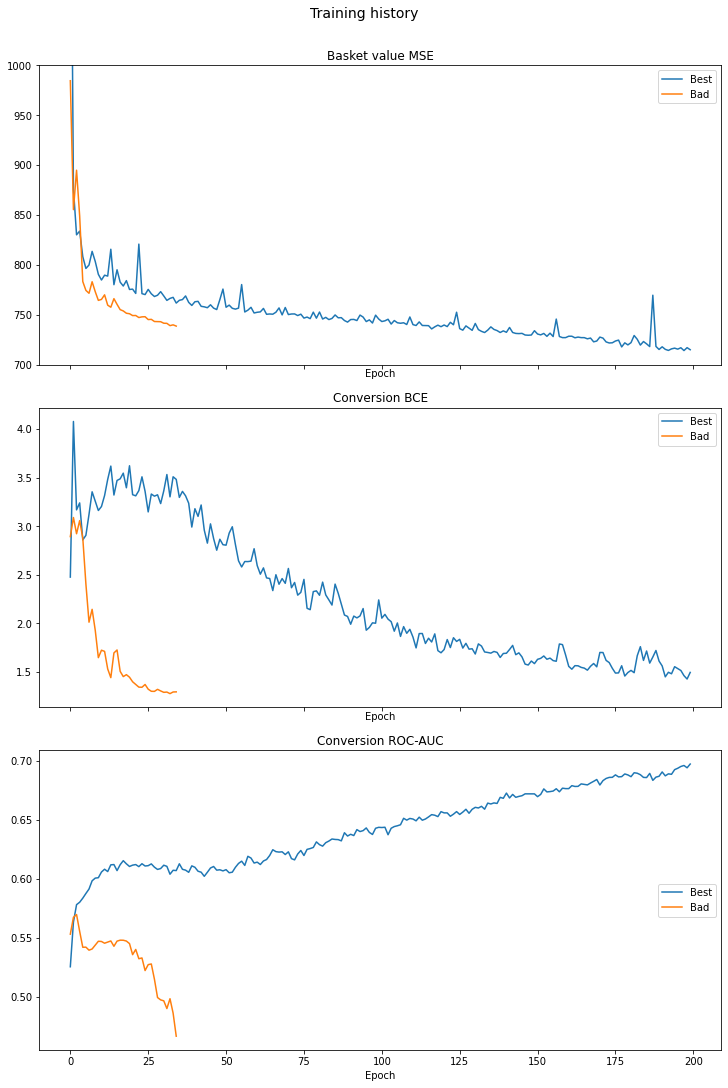

In [ ]:
params_best = top_results_bv.values[3]
params_bad = top_results_bv.values[4]
net_type = getattr(sys.modules[__name__], params_best[0])
path_best = dir_path + "hyperparam_tune2/training_history/%s_%s/%d_%d_%.4f_%d_%.1f.csv" % (params_best[0], params_best[1],
                                                                                           params_best[2], params_best[3],
                                                                                           params_best[4], params_best[5],
                                                                                           params_best[6])

path_bad = dir_path + "hyperparam_tune2/training_history/%s_%s/%d_%d_%.4f_%d_%.1f.csv" % (params_bad[0], params_bad[1],
                                                                                          params_bad[2], params_bad[3],
                                                                                          params_bad[4], params_bad[5],
                                                                                          params_bad[6])
history_best = pd.read_csv(path_best, index_col = 0)
history_bad = pd.read_csv(path_bad, index_col = 0)

f, axarr = plt.subplots(3, sharex=True, constrained_layout=True)
axarr[0].plot(history_best.basket_value_train_loss, label = 'Best')
axarr[0].plot(history_bad.basket_value_train_loss, label = 'Bad')
axarr[0].legend()
axarr[0].set_title('Basket value MSE')
axarr[0].set_xlabel('Epoch')
axarr[0].set_ylim(700, 1000)
axarr[1].plot(history_best.train_bce, label = 'Best')
axarr[1].plot(history_bad.train_bce, label = 'Bad')
axarr[1].legend()
axarr[1].set_title('Conversion BCE')
axarr[1].set_xlabel('Epoch')
axarr[2].plot(history_best.train_auc, label = 'Best')
axarr[2].plot(history_bad.train_auc, label = 'Bad')
axarr[2].legend(loc="center right")
axarr[2].set_title('Conversion ROC-AUC')
axarr[2].set_xlabel('Epoch')
f.suptitle('Training history', fontsize=14)
f.set_size_inches(10,15)
plt.show()

Training of the bad model was stopped early due to bad performance, hence why only values up to 35th epoch are plotted.

Evidently, despite the weighted BCE dropping early in the training, the AUC drops together with even blow 0.5, in case of the bad model, while the best model exhibits a relationship between AUC and BCE that is more in line with our expectations. Later in the training process the best model's BCE drops to lower values of BCE as well, while continuing improving the AUC performance. This jsut goes to show that relying solely on the BCE loss term for tracking a good conversion prediction performance is a bad idea.

In [ ]:
#take a closer look at the best performing model
net_type = getattr(sys.modules[__name__], params_best[0])
set_seed()
net = net_type(input_dim = 61, joint_layer_size = params_best[2], disjoint_layer_size = params_best[3], 
               criterion_y = mse_loss, criterion_c = bce_loss, drop = params_best[6], weighted = params_best[1])
state = torch.load(dir_path + 'hyperparam_tune2/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar' % 
                   (params_best[0], params_best[1], params_best[2], params_best[3], params_best[6], params_best[12], params_best[13], 
                    params_best[14], params_best[11]), map_location=torch.device('cpu'))
#load best state of the model and its optimizer
net.load_state_dict(state['model_state_dict'])
net.eval()
#evaluate the model
_, vauc, basket, c_hat_best, y_hat_best = evaluate(net, test_loader_mt)

In [ ]:
#take a closer look at the "bad" performing model
paramset = top_results_bv.values[1]
net_type = getattr(sys.modules[__name__], paramset[0])
set_seed()
net = net_type(input_dim = 61, joint_layer_size = paramset[2], disjoint_layer_size = paramset[3], 
               criterion_y = mse_loss, criterion_c = bce_loss, drop = paramset[6], weighted = paramset[1])
state = torch.load(dir_path + 'hyperparam_tune2/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar' % 
                   (paramset[0], paramset[1], paramset[2], paramset[3], paramset[6], paramset[12], paramset[13], 
                    paramset[14], paramset[11]), map_location=torch.device('cpu'))
#load best state of the model and its optimizer
net.load_state_dict(state['model_state_dict'])
net.eval()
#evaluate the model
_, vauc, basket, c_hat_bad, y_hat_bad = evaluate(net, test_loader_mt)

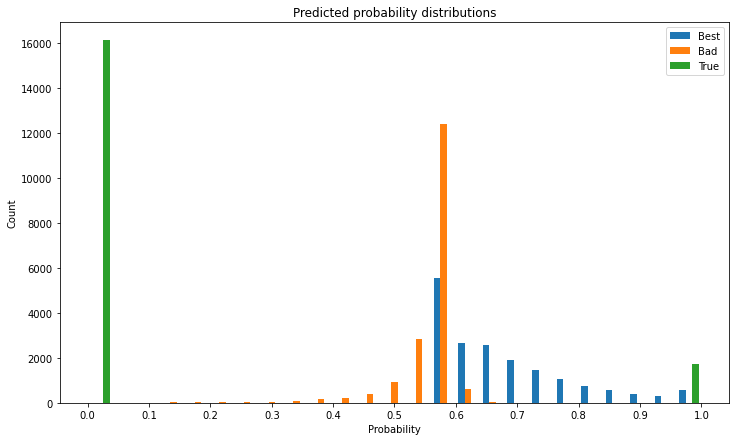

In [ ]:
plt.figure(figsize=(12,7))
plt.hist([c_hat_best.squeeze().numpy(), c_hat_bad.numpy().squeeze(), c_test.to_numpy()], bins=25, label=['Best', 'Bad', 'True'])
plt.legend()
plt.title('Predicted probability distributions')
plt.xlabel('Probability')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.ylabel('Count')
plt.show()

Taking a look at the predicted probabilities only reinforces the statement above, since the bad model predicts a probability (of a customer being converted) of around 0.57 for more than half of the observations in the test set. The best *MTXNet* is not perfect either, since it does not predict any probabilities lower than 0.55, but if we were to tune a threshold for determining what should be the lowest predicted probability, that translated into a customer being covnerted, we would have a more accurate class distribution. Obviously this is why the AUC of the best model is higher.

To conclude, the problem prioritization of one loss term over the other during training, mentioned in the previous sections, does not seem to be the root of a model's weak predictive power. Besides, it does not seem to depend on the network architecture choice. Based on our results, *MTNet*s are also able to learn both the regression and classification target simultaneously, although not as good, in comparison to other architectures. Therefore a specific choice of hyperparameters perhaps plays a more prevalent role in training multitask neural networks. 

Nevertheless, task loss prioritization still may play an underlying role in an MTL NN's convergence, since sometimes one tasks's loss advances faster
than the other. Consequently by the time the "slower" task
converges, the "faster" task will have already overfitted. This
highlights the necessity of balancing losses during training.

# 6. Additional Approaches for Model Improvement

As an attempt to improve the performance of the multitask neural networks by directly addressing the aforementioned problem, we explored two additional approaches that could result in a better model fit to the training data. Those approaches are:


*   Using different learning rates for different parts of a network architecture
*   Dynamic Weight Average

We employ these approaches on the *MTXNet* architecture, since it by far showed showed the lowest basket value MSE values out of all 3 introduced multitask architectures.

# 6.1 Different Learning Rates

Instead of organising a whole new hyperparameter search, we decided to utilize the knowledge gained from the previous part and apply different learning rates in training to the model configurations that already performed well in comparison to others. This follows the proposal of Caruana (1997) regarding learning rates in Backprop MTL closely. Each task-specific subnet, as well as the shared layers part of the network, receives its own learning rate that is different from other parts of the network. 

Apart from the *MTXNet* setup chosen as the best one in the previous section, the model that achieved the lowest basket value MSE among all multitask network configurations was also included into testing this approach. The latter achieved its highest AUC score on the validation on the 11th epoch, while the lowest basket value MSE was achieved on the 104th, which was a hint that the classification subnet should be trained a bit slower than other parts.

Due to the fact that all the model configurations that showed good performance had learning rates equal to either 0.0001, 0.0005, or 0.001, it seemed reasonable to focus on learning rates in the neighborhood of 0.0001-0.001 in this section. 

In [ ]:
# Specify a grid with 20 randomly drawn learning rate combinations
lr_grid = [0.00005, 0.00007, 0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005]
lr_list = list(itertools.product(lr_grid,lr_grid,lr_grid))
set_seed()
lr_list_sample = random.sample(lr_list, 20)
lr_list_sample

[(5e-05, 0.001, 0.0003),
 (7e-05, 7e-05, 0.0003),
 (7e-05, 5e-05, 0.0007),
 (0.0005, 0.0007, 5e-05),
 (0.0001, 7e-05, 0.0001),
 (0.005, 0.0005, 7e-05),
 (0.0003, 0.005, 5e-05),
 (0.0003, 7e-05, 0.0007),
 (0.003, 0.0007, 0.005),
 (0.0001, 0.001, 7e-05),
 (0.003, 0.001, 5e-05),
 (5e-05, 0.0005, 5e-05),
 (0.003, 0.0003, 7e-05),
 (0.005, 0.0007, 0.0005),
 (0.0001, 5e-05, 5e-05),
 (0.0007, 0.0005, 5e-05),
 (0.005, 5e-05, 0.0007),
 (0.0005, 0.005, 0.001),
 (0.001, 0.0003, 0.005),
 (0.0005, 0.001, 0.0001)]

In [ ]:
# Training neural nets with multiple learning rates
def separate_lr_tune(model, train_loader, val_loader, joint_lr, reg_lr, class_lr, epochs, path):

  net = model
  # Sepcify the optimization algorithm and learning rates for each part of the NN
  net.optimizer = optim.Adam([{'params': net.joint.parameters(), 'lr': joint_lr},
                              {'params': net.disjoint_c.parameters(), 'lr': class_lr},
                              {'params': net.output_c.parameters(), 'lr': class_lr},
                              {'params': net.disjoint_r.parameters(), 'lr': reg_lr},
                              {'params': net.output_r.parameters(), 'lr': reg_lr}])

  # Train the network
  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss, 
  net_min_bv_epoch, net_min_bv_auc, net_min_bv_yloss, net_history) = fit_mt(path = path, model = net,
                                                                         train_loader = train_loader,
                                                                         epochs = epochs,
                                                                         val_loader = val_loader)
  # Save training history
  net1_history.to_csv(dir_path + '%s/training_history/%s_%s/%.4f_%.4f_%.4f.csv' % 
                      (path, net.__class__.__name__, net.weighted, joint_lr, class_lr, reg_lr))
  res = [net.__class__.__name__, net.weighted, net.joint_layer_size, net.disjoint_layer_size, net.drop,
         joint_lr, class_lr, reg_lr, net_max_auc_epoch, net_max_auc, net_max_auc_loss,
         net_max_auc_bv_loss, net_min_bv_loss, net_min_bv_epoch, net_min_bv_auc, net_min_bv_yloss]

  return res

In [ ]:
# Training neural nets with multiple learning rates
results = []
for lrs in lr_list_sample:
  # First train the MTXNet with the best set of hyperparameters
  set_seed()
  # Specify a PyTorch specific data loader that will feed data to the model
  train_loader1 = DataLoader(data_train_mt, batch_size = 512, shuffle = True)
  set_seed()
  # Instantiate a neural net
  model1 = MTXNet(61, 512, 128, mse_loss, bce_loss, 0.5, weighted = True).to(device)
  # Send model to training
  paramset_res1 = separate_lr_tune(model1, train_loader1, val_loader_mt, lrs[0], lrs[1], lrs[2], 
                                   epochs = 200, path = 'separate_lr_tune')
  # Store training results
  results.extend(paramset_res1)
  set_seed()
  # Analogously for the second MTXnet configuration
  train_loader2 = DataLoader(data_train_mt, batch_size = 128, shuffle = True)
  set_seed()
  model2 = MTXNet(61, 256, 256, mse_loss, bce_loss, 0.3, weighted = True).to(device)
  paramset_res2 = separate_lr_tune(model2, train_loader2, val_loader_mt, lrs[0], lrs[1], lrs[2], 
                                   epochs = 200, path = 'separate_lr_tune')
  results.extend(paramset_res2)

# Store training results to disk
results = np.array(results)
np.save(dir_path + 'separate_lr_tune/lr_tune_results.npy', results)
print('Separate lr tuning completed!')

In [ ]:
separate_lr_res = np.load(dir_path + 'separate_lr_tune/lr_tune_results2.npy', allow_pickle=True)
lr_res_reshaped = separate_lr_res.reshape(-1, 16)
cols = ['type', 'weighted', 'joint_dim', 'disjoint_dim', 'dropout', 'joint_lr', 'class_lr',
        'reg_lr', 'net_max_auc_epoch', 'net_max_auc', 'net_max_auc_loss', 'net_max_auc_bv_loss',
        'net_min_bv_loss', 'net_min_bv_epoch', 'net_min_bv_auc', 'net_min_bv_total_loss']
lr_res_framed = pd.DataFrame(lr_res_reshaped, columns = cols)
lr_res_framed[cols] = lr_res_framed[cols].apply(pd.to_numeric, errors = 'ignore')
lr_res_framed = lr_res_framed.astype({"net_max_auc_epoch": int, "net_min_bv_epoch": int})
top_res_bv_mse = lr_res_framed.sort_values(by=['net_min_bv_loss'], ascending=True).head(10)
top_res_auc = lr_res_framed.sort_values(by=['net_max_auc'], ascending=False).head(5)

Unfortunately using different learning rates for different parts of the network architecture did not result in any improvements. After evaluating 8 best NN configurations with respect to the basket value MSE on the validation set, we obtained the following results:

In [ ]:
#evaluate top performing networks wrt validation basket value mse
auc_arr_bv = []
bv_mse_arr_bv = []
for paramset in top_res_bv_mse.values:
  net_type = getattr(sys.modules[__name__], paramset[0])
  net = net_type(input_dim = 61, joint_layer_size = paramset[2], disjoint_layer_size = paramset[3], 
                 criterion_y = mse_loss, criterion_c = bce_loss, drop = paramset[4], weighted = paramset[1]).to(device)
  state = torch.load(dir_path + 'separate_lr_tune/models/model_%s_%s_%d_%d_%.1f_%d_%.4f_%.4f_%.4f.tar' % 
                     (paramset[0], paramset[1], paramset[2], paramset[3], paramset[4], paramset[13], paramset[14], 
                      paramset[15], paramset[12]), map_location=torch.device('cpu'))
  #load best state of the model and its optimizer
  net.load_state_dict(state['model_state_dict'])
  net.eval()
  #evaluate the models
  test_loss, test_auc, basket_mse, _, _ = evaluate(net, test_loader_mt)
  auc_arr_bv.append(test_auc)
  bv_mse_arr_bv.append(basket_mse)

print("Table 3:")
top_res_bv_mse.iloc[:, :8].assign(test_auc = auc_arr_bv, baket_value_test_mse = bv_mse_arr_bv).reset_index(drop=True).head(8)

Table 3:


,type,weighted,joint_dim,disjoint_dim,dropout,joint_lr,class_lr,reg_lr,test_auc,baket_value_test_mse
0,MTXNet,False,256,256,0.3,0.00010,0.00005,0.00005,0.549985,756.726685
1,MTXNet,False,256,256,0.3,0.00007,0.00030,0.00007,0.590733,758.312439
2,MTXNet,False,256,256,0.3,0.00010,0.00010,0.00007,0.550595,757.418030
3,MTXNet,False,256,256,0.3,0.00007,0.00070,0.00005,0.510409,757.101624
4,MTXNet,False,256,256,0.3,0.00030,0.00070,0.00007,0.500000,758.310974
5,MTXNet,False,256,256,0.3,0.00070,0.00005,0.00050,0.386764,760.112427
6,MTXNet,False,256,256,0.3,0.00005,0.00030,0.00100,0.605552,762.112671
7,MTXNet,True,512,128,0.5,0.00050,0.00005,0.00070,0.630039,764.180603


Comparing them to results of multitask models that were trained with a uniform learning rate, multiple learning rates show inferior performance. The second configuration in Table 3 resulted in a slight AUC improvement over the baseline configuration of the same model, however the AUC is still below 0.6, which is unsatisfying. The best *MTXNet* configuration also showcased a performance deterioration in a multiple learning rate setting (last row in Table 3).

# 6.2 Dynamic Weight Average




The Dynamic Weight Average (DWA) is an adaptive task weighting approach introduced by Liu (2018) that learns to average task weighting over time by considering the rate of change of loss for each task. More formally, it defines the loss function in a setup with $K$ tasks as a linear combination of task-specific losses $\ell_i$ with task weightings $\lambda_i$. Translated into our setting, we get:

\begin{equation}
L = \lambda_1 MSE + \lambda_2 wBCE,
\end{equation}

where each weighting $\lambda_k$ for task $k$: 

\begin{equation}
\lambda_k(t):= \frac{Kexp(w_k(t-1)/T)}{\sum_iexp(w_k(t-1)/T)}, \\\ w_k(t-1)=\frac{\ell_k(t-1)}{\ell_k(t-2)}
\end{equation}

with $t$ being an epoch index, and $T$ being an exogenous temperature parameter that controls the softness of the task weighting. $T$ thus becomes an additional hyperparameter in a neural network training, since it determines the weighting distribution between tasks - the larger its value, the more even is the distribution between tasks. If $T$ is large enough, $\lambda_i \approx$ 1.

# 6.2.1 Implementation

Again the DWA method was applied to the *MTXNet* architecture with a uniform learning rate, since it showed the best performance out of all multitask nets so far. We incorporated it into a function that trains a given neural network: 

In [ ]:
class DAW_MTXNet(MTXNet):

  def __init__(self, input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted):

    super().__init__(input_dim, joint_layer_size, disjoint_layer_size, criterion_y, criterion_c, drop, weighted)

  def train_iteration(self, lambda1, lambda2, data_loader):
    running_loss = 0.0
    train_loss_mse = 0.0
    train_loss_bce = 0.0
    basket_value_train_mse = 0.0
    c_pred = []
    c_true = []
    for i, (X,y,c,w) in enumerate(data_loader):

      pred = self(X)
      c_hat, y_hat = pred[0], pred[1]

      c_pred.extend(c_hat.squeeze())
      #since the dataset is reshuffled after each epoch, need an array with true values of c
      #for positional consistency with the predicted ones
      c_true.extend(c)

      loss1 = self.criterion_y(y_hat.squeeze(), y)

      if self.weighted == True:
        weighted_criterion = nn.BCELoss(weight = w)
        loss2 = weighted_criterion(c_hat.squeeze(), c)
      else:
        loss2 = self.criterion_c(c_hat.squeeze(), c)

      loss = lambda1*loss1 + lambda2*loss2

      self.optimizer.zero_grad()        
      loss.backward()
      self.optimizer.step()
      
      loss = loss1 + loss2
      running_loss += loss.item()
      train_loss_mse += loss1.item()
      train_loss_bce += loss2.item()

    n_batches = int(np.ceil(len(data_loader.dataset)/data_loader.batch_size))
    running_loss = running_loss/n_batches
    basket_value_train_mse = basket_value_train_mse/n_batches
    train_loss_mse = train_loss_mse/n_batches
    train_loss_bce = train_loss_bce/n_batches
    basket_value_train_mse = train_loss_mse

    train_auc = roc_auc_score(torch.Tensor(c_true), torch.Tensor(c_pred))

    return running_loss, train_auc, train_loss_mse, train_loss_bce, basket_value_train_mse

In [ ]:
def daw_fit_showcase(model, path, train_loader, epochs, val_loader, temp):

  # For t=1,2 we set equal task weightings
  lambda1 = 1
  lambda2 = 1

  # Temperature parameter as a PyTorch tensor
  T = torch.tensor([temp], dtype=float, device=device, requires_grad=False)

  train_mse_previous = 0
  train_bce_previous = 0

  for epoch in range(epochs):
    # Set model into training mode - dropout is activated and gradients are calculated
    model.train()
    running_loss, train_auc, train_mse, train_bce, train_bv_loss = model.train_iteration(lambda1, lambda2, train_loader)
    # Set model into evaluation mode - e.g. dropout is deactivated and no gradients are calculated
    model.eval()
    val_loss, val_auc, val_mse, val_bce, val_bv_loss = model.val_iteration(val_loader)
    
    if epoch>1:
        print("Loss Y: ", train_mse, " Loss Y_prev: ", train_mse_prev)
        print("Loss C: ", train_bce, " Loss C_prev: ", train_bce_prev)
        # Calculate relative descending rate of the losses
        w1 = train_mse/train_mse_previous
        w2 = train_bce/train_bce_previous
        try:
          # Calculate the task weightings
          lambda1 = 2*math.exp(w1/T)/(math.exp(w1/T)+math.exp(w2/T))
          lambda2 = 2*math.exp(w2/T)/(math.exp(w1/T)+math.exp(w2/T))
        except OverflowError:
          # Sometimes the relative descending rate can get too large, which causes the exp function to throw
          # an Overflow Error. In order to mitigate this issue, we decided to simply reset the task weightings
          # to being equal again
          lambda1 = 1
          lambda2 = 1

    print("Lambda1: ", lambda1, " - Lambda2: ", lambda2)
    
    train_mse_previous = train_mse
    train_bce_previous = train_bce

daw_fit_showcase was used only for display purposes for the blogpost!! For actual training the daw_fit function below was used!

In [ ]:

def daw_fit(model, path, train_loader, epochs, val_loader, temp, th_auc, th_loss, th_stop):
  val_auc_list = []
  val_bv_loss_list = []
  cols = ['epoch', 'train_loss', 'basket_value_train_loss', 'train_auc', 'train_mse', 'train_bce', 
          'val_loss', 'basket_value_val_loss', 'val_auc', 'val_mse', 'val_bce', 'lambda1', 'lambda2']
  history = pd.DataFrame(columns = cols, index = range(epochs))
  lambda1 = 1
  lambda2 = 1
  T = torch.tensor([temp], dtype=float, device=device, requires_grad=False)
  train_mse_prev = 0
  train_bce_prev = 0
  for epoch in range(epochs):
    model.train()
    running_loss, train_auc, train_mse, train_bce, train_bv_loss = model.train_iteration(lambda1, lambda2, train_loader)
    model.eval()
    val_loss, val_auc, val_mse, val_bce, val_bv_loss = model.val_iteration(val_loader)
    
    if epoch>1:
        print("Loss Y: ", train_mse, " Loss Y_prev: ", train_mse_prev)
        print("Loss C: ", train_bce, " Loss C_prev: ", train_bce_prev)
        w1 = train_mse/train_mse_prev
        w2 = train_bce/train_bce_prev
        try:
          lambda1 = 2*math.exp(w1/T)/(math.exp(w1/T)+math.exp(w2/T))
          lambda2 = 2*math.exp(w2/T)/(math.exp(w1/T)+math.exp(w2/T))
        except OverflowError:
          lambda1 = 1
          lambda2 = 1

    print("Lambda1: ", lambda1, " - Lambda2: ", lambda2)
    
    train_mse_prev = train_mse
    train_bce_prev = train_bce

    #print out training information
    print('[%d] loss: %.4f | bv train loss: %.4f | validation loss: %.4f | bv val loss: %.4f | auc: %.4f | val_auc: %.4f' % 
          (epoch+1, running_loss, train_bv_loss, val_loss, val_bv_loss, train_auc, val_auc))
    #save good performing models
    if val_auc>th_auc:
      if len(val_auc_list)>1 and val_auc>max(val_auc_list):
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': model.optimizer.state_dict()},
            dir_path + "%s/models/model_%s_%s_%d_%d_%.1f_%.2f_%d_%.4f_%.4f_%.4f.tar" % 
            (path, model.__class__.__name__, model.weighted, model.joint_layer_size, model.disjoint_layer_size, 
             model.drop, temp, epoch+1, val_auc, val_loss, val_bv_loss))
    #also add saving based on bv loss
    if val_bv_loss<th_loss: 
      if len(val_bv_loss_list)>1 and val_bv_loss<min(val_bv_loss_list):
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': model.optimizer.state_dict()},
            dir_path + "%s/models/model_%s_%s_%d_%d_%.1f_%.2f_%d_%.4f_%.4f_%.4f.tar" % 
            (path, model.__class__.__name__, model.weighted, model.joint_layer_size, model.disjoint_layer_size, 
             model.drop, temp, epoch+1, val_auc, val_loss, val_bv_loss))
    val_auc_list.append(val_auc)
    val_bv_loss_list.append(val_bv_loss)
    values = [epoch+1, running_loss, train_bv_loss, train_auc, train_mse, train_bce, val_loss, val_bv_loss,
              val_auc, val_mse, val_bce, lambda1, lambda2]
    history.iloc[epoch] = values
    #'early stopping'
    if len(val_auc_list)>th_stop and all(i < 0.52 for i in val_auc_list[-th_stop:]):
      break

  history[cols] = history[cols].apply(pd.to_numeric, errors = 'ignore')

  max_auc = max(history['val_auc'])
  max_auc_loss = history['val_loss'][history['val_auc'].argmax()]
  max_auc_epoch = history['epoch'][history['val_auc'].argmax()]
  max_auc_bv_loss = history['basket_value_val_loss'][history['val_auc'].argmax()]

  min_val_bv_loss = min(history['basket_value_val_loss'])
  min_val_bv_epoch = history['epoch'][history['basket_value_val_loss'].argmin()]
  min_val_bv_auc = history['val_auc'][history['basket_value_val_loss'].argmin()]
  min_val_bv_yloss = history['val_loss'][history['basket_value_val_loss'].argmin()]

  return (max_auc, max_auc_loss, max_auc_epoch, max_auc_bv_loss, min_val_bv_loss, min_val_bv_epoch, 
          min_val_bv_auc, min_val_bv_yloss, history)

# 6.2.2 Hyperparameter Tuning

In [ ]:
def daw_tune(joint_dim, disjoint_dim, lr, batch, drop, temp, path, th_auc, th_loss, th_stop):

  set_seed()
  train_loader = DataLoader(data_train_mt, batch_size = batch, shuffle = True)
  epochs = 200
  res = []

  set_seed()
  net = DAW_MTXNet(61, joint_dim, disjoint_dim, mse_loss, bce_loss, drop, weighted = False).to(device)
  net.optimizer = optim.Adam(net.parameters(), lr=lr)

  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss, 
  net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss, net_history) = daw_fit(path = path, model = net, 
                                                                                 train_loader = train_loader, 
                                                                                 epochs = epochs, 
                                                                                 val_loader = val_loader_mt, 
                                                                                  temp = temp,
                                                                                  th_auc = th_auc,
                                                                                  th_loss = th_loss,
                                                                                  th_stop = th_stop)
  net_history.to_csv(dir_path + '%s/training_history/%s_%s/%d_%d_%.4f_%d_%.1f_%.2f.csv' % 
                     (path, net.__class__.__name__, net.weighted, joint_dim, disjoint_dim, lr, batch, drop, temp))
  res.append([net.__class__.__name__, net.weighted, joint_dim, disjoint_dim, lr, batch, drop, temp, 
              net_max_auc_epoch, net_max_auc, net_max_auc_loss, net_max_auc_bv_loss, net_min_bv_loss, 
              net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss])

  set_seed()
  net = DAW_MTXNet(61, joint_dim, disjoint_dim, mse_loss, bce_loss, drop, weighted = True).to(device)
  net.optimizer = optim.Adam(net.parameters(), lr=lr)

  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss,
  net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss, net_history) = daw_fit(path = path, model = net,
                                                                                 train_loader = train_loader,
                                                                                 epochs = epochs,
                                                                                  val_loader = val_loader_mt,
                                                                                  temp = temp, th_auc=th_auc,
                                                                                  th_loss=th_loss, th_stop=th_stop)
  
  net_history.to_csv(dir_path + '%s/training_history/%s_%s/%d_%d_%.4f_%d_%.1f_%.2f.csv' % 
                     (path, net.__class__.__name__, net.weighted, joint_dim, disjoint_dim, lr, batch, drop, temp))
  res.append([net.__class__.__name__, net.weighted, joint_dim, disjoint_dim, lr, batch, drop, temp,
              net_max_auc_epoch,net_max_auc, net_max_auc_loss, net_max_auc_bv_loss, net_min_bv_loss,
              net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss])

  return res

Since there was a need to find an optimal temperature parameter, we decided to tune all other hyperparameters of the model as well. Once more all sets of hyperparameter were trained in combination with both the weighted and regular BCE loss terms.

In [ ]:
param_grid_ext = {'joint_dim' : [128, 256, 512], 'disjoint_dim' : [64, 128, 256], 
                  'lr' : [0.0001, 0.0003, 0.0005, 0.001, 0.005, 0.01, 0.05], 'batch' : [128, 256, 512, 1024],
              'drop' : [0.1, 0.2, 0.3, 0.4, 0.5], 'temp' : [0.01, 0.05, 0.1, 0.3, 0.7, 1, 3, 7]}
keys, values = zip(*param_grid_ext.items())
paramlist_ext = list(itertools.product(*values))
set_seed()
grid_sample_ext = random.sample(paramlist_ext, 20)
grid_sample_ext

[(128, 64, 0.01, 1024, 0.1, 3),
 (128, 128, 0.0005, 256, 0.3, 0.7),
 (128, 128, 0.0003, 512, 0.4, 3),
 (256, 256, 0.0003, 1024, 0.5, 0.3),
 (128, 256, 0.001, 256, 0.2, 0.1),
 (256, 128, 0.001, 512, 0.2, 0.01),
 (256, 64, 0.005, 1024, 0.1, 0.05),
 (512, 256, 0.05, 128, 0.1, 7),
 (256, 64, 0.0001, 512, 0.5, 0.7),
 (512, 256, 0.05, 128, 0.3, 1),
 (128, 64, 0.001, 512, 0.4, 0.05),
 (512, 256, 0.001, 512, 0.1, 0.1),
 (128, 256, 0.0005, 128, 0.5, 0.1),
 (512, 64, 0.0005, 128, 0.3, 0.01),
 (256, 256, 0.01, 256, 0.1, 7),
 (512, 128, 0.001, 128, 0.3, 0.7),
 (256, 256, 0.001, 128, 0.2, 7),
 (512, 128, 0.05, 512, 0.5, 0.3),
 (512, 64, 0.001, 512, 0.2, 0.01),
 (512, 128, 0.0005, 256, 0.4, 0.05)]

In [ ]:
# Training DAW
results = []
for paramset in grid_sample_ext:
  paramset_result = daw_tune(paramset[0], paramset[1], paramset[2], paramset[3], 
                             paramset[4], paramset[5], path = 'daw_tune', 
                             th_auc = 0.64,th_loss = 771,th_stop = 9)
  results.extend(paramset_result)

daw_results = np.array(results)
np.save(dir_path + 'daw_tune/tune_results_daw.npy', daw_results)
print('DAW training completed!')

# 6.2.3 Evaluation

In [ ]:
# Pull the summary together
daw_res = np.load(dir_path + 'daw_tune/tune_results_daw.npy')

cols = ['type', 'weighted', 'joint_dim', 'disjoint_dim', 'lr', 'batch_size', 'dropout',
        'temp', 'max_val_auc_epoch', 'max_val_auc', 'max_val_auc_loss', 'max_val_auc_bv_loss',
        'min_bv_loss', 'min_bv_loss_epoch', 'min_bv_loss_auc', 'min_bv_yloss']
res_framed = pd.DataFrame(daw_res, columns = cols)
res_framed[cols] = res_framed[cols].apply(pd.to_numeric, errors = 'ignore')
res_framed = res_framed.astype({"max_val_auc_epoch": int, "min_bv_loss_epoch": int})
top_results_daw = res_framed.sort_values(by=['min_bv_loss'], ascending=True).head(10)
top_results_daw

,type,weighted,joint_dim,disjoint_dim,lr,batch_size,dropout,temp,max_val_auc_epoch,max_val_auc,max_val_auc_loss,max_val_auc_bv_loss,min_bv_loss,min_bv_loss_epoch,min_bv_loss_auc,min_bv_yloss
2,DAW_MTXNet,False,128,128,0.0005,256,0.3,0.70,66,0.662252,753.575439,752.067505,751.132568,71,0.659357,752.562378
3,DAW_MTXNet,True,128,128,0.0005,256,0.3,0.70,79,0.664586,755.284241,753.882019,752.295166,88,0.662933,754.010559
21,DAW_MTXNet,True,128,64,0.0010,512,0.4,0.05,115,0.666484,755.895203,754.295715,753.044495,100,0.665013,756.610657
9,DAW_MTXNet,True,128,256,0.0010,256,0.2,0.10,75,0.657716,765.979553,764.379517,753.522461,62,0.611991,754.551819
32,DAW_MTXNet,False,256,256,0.0010,128,0.2,7.00,28,0.605179,772.995972,772.436523,753.983582,16,0.544691,754.604736
12,DAW_MTXNet,False,256,64,0.0050,1024,0.1,0.05,9,0.454103,1350.024536,1349.323120,754.041809,5,0.392996,754.716675
20,DAW_MTXNet,False,128,64,0.0010,512,0.4,0.05,102,0.664385,759.100769,756.618225,754.560120,121,0.662302,757.465881
8,DAW_MTXNet,False,128,256,0.0010,256,0.2,0.10,24,0.654946,765.326050,759.238831,754.661377,38,0.534534,758.078918
23,DAW_MTXNet,True,512,256,0.0010,512,0.1,0.10,38,0.645439,784.453613,760.976135,755.613342,34,0.583843,819.181580
33,DAW_MTXNet,True,256,256,0.0010,128,0.2,7.00,1,0.412050,781.042297,780.288879,756.226257,8,0.347213,756.910828


Obesrving the performance of the best 5 *MTXNet* models, no significant improvements over an equal task weighting were achieved. The only model configuration that can be considered as a slight improvement can be found in the top row of Table 4 - AUC increased from 0.632 to 0.643, while the basket value MSE increased only marginally from 758.8 to 759.2. A combination of DWA and *MTXNet* is now barely on the same level of performance as a Hurdle Linear model consisting of the Linear and Logistic Regressions. Although we have hoped for a more significant performance improvement, unfortunately this is the best results that we could achieve.

In [ ]:
#evaluate top performing networks wrt validation basket value mse
auc_arr_bv = []
bv_mse_arr_bv = []
for paramset in top_results_daw.values:
  net_type = getattr(sys.modules[__name__], paramset[0])
  net = net_type(input_dim = 61, joint_layer_size = paramset[2], disjoint_layer_size = paramset[3], 
                 criterion_y = mse_loss, criterion_c = bce_loss, drop = paramset[6], weighted = paramset[1]).to(device)
  state = torch.load(dir_path + 'daw_tune/models/model_%s_%s_%d_%d_%.1f_%.2f_%d_%.4f_%.4f_%.4f.tar' %
                     (paramset[0], paramset[1], paramset[2], paramset[3], paramset[6], paramset[7],
                      paramset[13], paramset[14], paramset[15], paramset[12]), map_location=torch.device('cpu'))
  #load best state of the model and its optimizer
  net.load_state_dict(state['model_state_dict'])
  net.eval()
  #evaluate the models
  test_loss, test_auc, basket_mse, _, _ = evaluate(net, test_loader_mt)
  auc_arr_bv.append(test_auc)
  bv_mse_arr_bv.append(basket_mse)

print("Table 4:")
top_results_daw.iloc[:, :8].assign(test_auc = auc_arr_bv, baket_value_test_mse = bv_mse_arr_bv).sort_values(by=['baket_value_test_mse'], ascending=True).reset_index(drop=True).head(5)

Table 4:


,type,weighted,joint_dim,disjoint_dim,lr,batch_size,dropout,temp,test_auc,baket_value_test_mse
0,DAW_MTXNet,True,128,64,0.0010,512,0.4,0.05,0.642534,759.207092
1,DAW_MTXNet,False,128,128,0.0005,256,0.3,0.70,0.635730,762.509583
2,DAW_MTXNet,True,512,256,0.0010,512,0.1,0.10,0.578923,763.064331
3,DAW_MTXNet,False,128,64,0.0010,512,0.4,0.05,0.637028,763.118835
4,DAW_MTXNet,True,128,128,0.0005,256,0.3,0.70,0.637636,763.615295


In [ ]:
best_mt_params = top_results_daw.iloc[2]

In [ ]:
best_daw_params = top_results_daw.iloc[2]
net_type = getattr(sys.modules[__name__], best_daw_params[0])
net = net_type(input_dim = 61, joint_layer_size = best_daw_params[2], disjoint_layer_size = best_daw_params[3],
               criterion_y = mse_loss, criterion_c = bce_loss, drop = best_daw_params[6], 
               weighted = best_daw_params[1]).to(device)
state = torch.load(dir_path + 'daw_tune/models/model_%s_%s_%d_%d_%.1f_%.2f_%d_%.4f_%.4f_%.4f.tar' %
                   (best_daw_params[0], best_daw_params[1], best_daw_params[2], best_daw_params[3], best_daw_params[6],
                    best_daw_params[7], best_daw_params[13], best_daw_params[14], best_daw_params[15],
                    best_daw_params[12]), map_location=torch.device('cpu'))
#load best state of the model and its optimizer
net.load_state_dict(state['model_state_dict'])
net.eval()
#evaluate the models
_, _, _, c_hat_test, y_hat_test = evaluate(net, test_loader_mt)

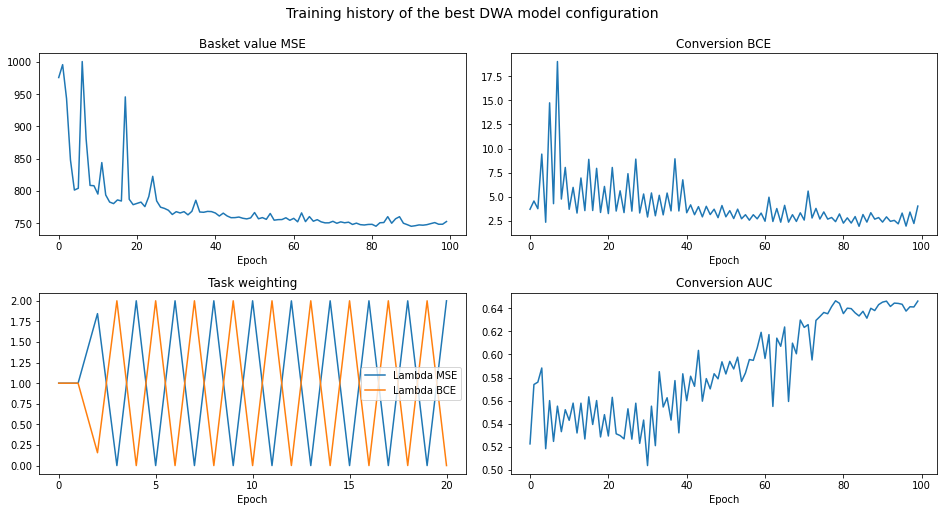

In [ ]:
path_best_dwa = dir_path + "daw_tune/training_history/%s_%s/%d_%d_%.4f_%d_%.1f_%.2f.csv" % (best_daw_params[0], best_daw_params[1],
                                                                                           best_daw_params[2], best_daw_params[3],
                                                                                           best_daw_params[4], best_daw_params[5],
                                                                                           best_daw_params[6], best_daw_params[7])
other_params = top_results_daw.iloc[0]
path_other_dwa = dir_path + "daw_tune/training_history/%s_%s/%d_%d_%.4f_%d_%.1f_%.2f.csv" % (other_params[0], other_params[1],
                                                                                           other_params[2], other_params[3],
                                                                                           other_params[4], other_params[5],
                                                                                           other_params[6], other_params[7])


history_best_dwa = pd.read_csv(path_best_dwa, index_col = 0)
history_other_dwa = pd.read_csv(path_other_dwa, index_col = 0)

f, axarr = plt.subplots(2, 2, constrained_layout=True)
axarr[0][0].plot(history_best_dwa.basket_value_train_loss[0:100])
axarr[0][0].set_title('Basket value MSE')
axarr[0][0].set_xlabel('Epoch')
axarr[1][0].plot(history_best_dwa.lambda1[0:21], label = 'Lambda MSE')
axarr[1][0].plot(history_best_dwa.lambda2[0:21], label = 'Lambda BCE')
axarr[1][0].set_xticks(np.arange(0, 21, step=5))
axarr[1][0].legend()
axarr[1][0].set_title('Task weighting')
axarr[1][0].set_xlabel('Epoch')
axarr[0][1].plot(history_best_dwa.train_bce[0:100])
axarr[0][1].set_title('Conversion BCE')
axarr[0][1].set_xlabel('Epoch')
axarr[1][1].plot(history_best_dwa.train_auc[0:100])
axarr[1][1].set_title('Conversion AUC')
axarr[1][1].set_xlabel('Epoch')
f.suptitle('Training history of the best DWA model configuration', fontsize=14)
f.set_size_inches(13,7)
plt.show()

However this behaviour is not inherent to the DWA approach. Below the training history of the second best DWA model configuration is shown as an illustration for that. There the $\lambda$ values are more heterogenous. This, however does not necessarily translate to a better performance.

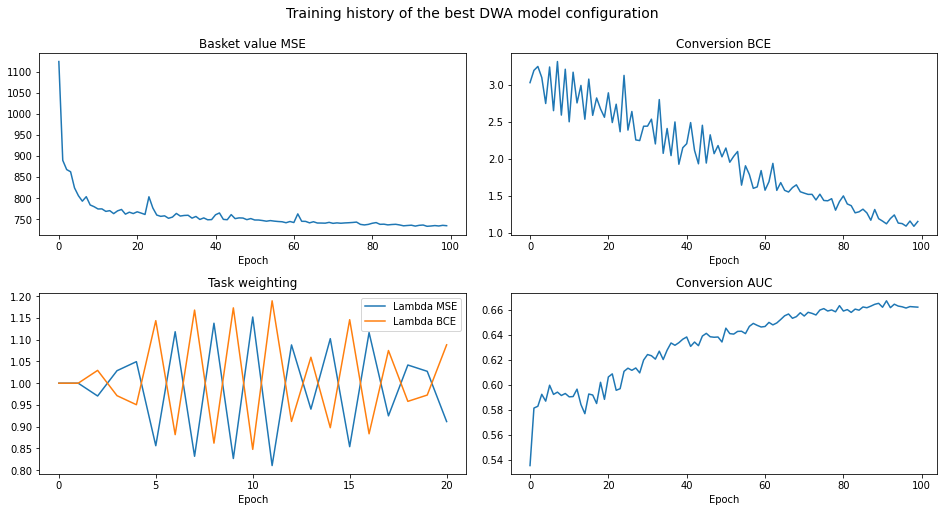

In [ ]:
f, axarr = plt.subplots(2, 2, constrained_layout=True)
axarr[0][0].plot(history_other_dwa.basket_value_train_loss[0:100])
axarr[0][0].set_title('Basket value MSE')
axarr[0][0].set_xlabel('Epoch')
axarr[1][0].plot(history_other_dwa.lambda1[0:21], label = 'Lambda MSE')
axarr[1][0].plot(history_other_dwa.lambda2[0:21], label = 'Lambda BCE')
axarr[1][0].set_xticks(np.arange(0, 21, step=5))
axarr[1][0].legend()
axarr[1][0].set_title('Task weighting')
axarr[1][0].set_xlabel('Epoch')
axarr[0][1].plot(history_other_dwa.train_bce[0:100])
axarr[0][1].set_title('Conversion BCE')
axarr[0][1].set_xlabel('Epoch')
axarr[1][1].plot(history_other_dwa.train_auc[0:100])
axarr[1][1].set_title('Conversion AUC')
axarr[1][1].set_xlabel('Epoch')
f.suptitle('Training history of the best DWA model configuration', fontsize=14)
f.set_size_inches(13,7)
plt.show()

At last we compare the predictions of the best DWA model configuration with the true values in the test set. As one can see, the predicted conversion probability distribution now has 2 peaks, compared to the vanilla *MTXNet*, while it still mostly is located in the range of >0.55. The expected basket values still are very sparse in the region of >50.

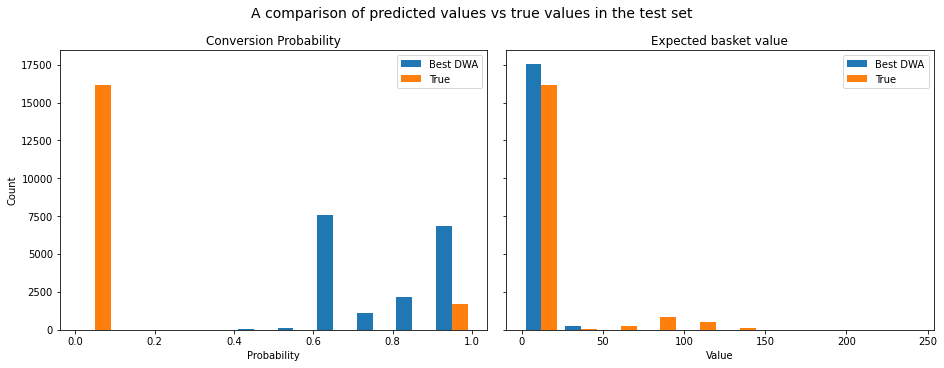

In [ ]:
f, axarr = plt.subplots(1, 2, sharey=True, constrained_layout=True)
axarr[0].hist([c_hat_test.squeeze().numpy(), c_test.to_numpy()], bins=10, label=['Best DWA', 'True'])
axarr[0].set_title('Conversion Probability')
axarr[0].set_xlabel('Probability')
axarr[0].set_ylabel('Count')
axarr[0].legend()
axarr[1].hist([y_hat_test.squeeze().numpy(), y_test.to_numpy()], label = ['Best DWA', 'True'])
axarr[1].set_title('Expected basket value')
axarr[1].set_xlabel('Value')
axarr[1].legend()
f.suptitle('A comparison of predicted values vs true values in the test set', fontsize=14)
f.set_size_inches(13,5)
plt.show()

Most of the predcited basket values are concentrated in the range between 0 and 20, however none of the predicted values are actually equal to zero.

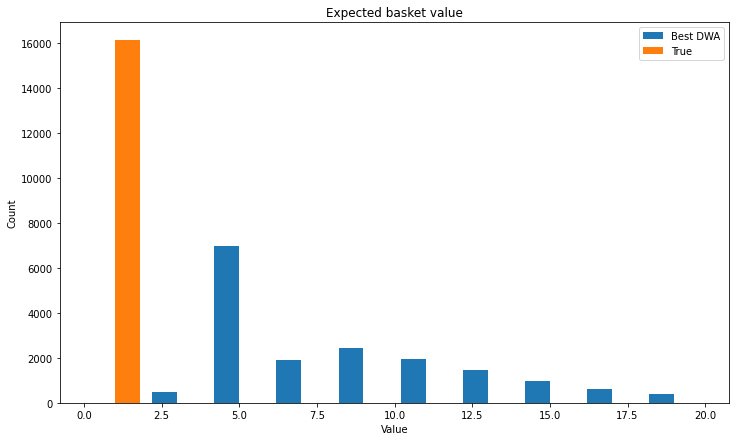

In [ ]:
plt.figure(figsize=(12,7))
plt.title("Expected basket value")
plt.hist([y_hat_test[y_hat_test<20].squeeze().numpy(), y_test[y_test<20].to_numpy()], bins = 10,label = ['Best DWA', 'True'])
plt.ylabel("Count")
plt.xlabel("Value")
plt.legend()
plt.show()

Despite having subpar results with multitask neural networks, the goal of our topic is using these multitask neural nets to analyze causal implications of a marketing campaign. Therefore we proceed to the next part of this paper, where we estimate CATEs using our models.

# 7. Benchmark Causal Hurdle Two-Model Approach

The two-model hurdle architecture is explained by Haupt and Lessmann (2020) as equivalent to the combination of two hurdle models estimating conversion probability and checkout amount, for each of treatment and control groups as in the two-model approach for CATE. In order to implement this, first of all, the dataset is split into two as treated and control groups. Then, a hurdle model is fit to treated and control data samples separately. In order to calculate the individual treatment effect, all data samples (both treated and control combined) are used as inputs to the two hurdle models. The outputs from the two hurdle models indicate what the probability of conversion and expected checkout amount would be for each customer, in the cases that they are treated or not. The difference between these two outputs yields the individual treatment effect.



In [ ]:
# Benchmark Causal Hurdle Two-Model Approach (Log-Lin Regression)

x_train_t = x_train[g_train==1]
x_train_nt = x_train[g_train==0]
c_train_t = c_train[g_train==1]
c_train_nt = c_train[g_train==0]
y_train_t = y_train[g_train==1]
y_train_nt = y_train[g_train==0]

x_test_t = x_test[g_test==1]
x_test_nt = x_test[g_test==0]
c_test_t = c_test[g_test==1]
c_test_nt = c_test[g_test==0]
y_test_t = y_test[g_test==1]
y_test_nt = y_test[g_test==0]

print(y_train_nt[c_train_nt==1].median())
print(y_train_t[c_train_t==1].median())


89.83344268798831
91.67892408738825


The train dataset is split into two: treatment and control groups. The median checkout amount for the control group is €89.8 and €91.7 for the treatment group, considering only those who have converted. It is observed from the plot below, that the checkout amount is distributed with higher values for the treatment group, showing the causal relationship between the marketing campaign and the checkout amount.

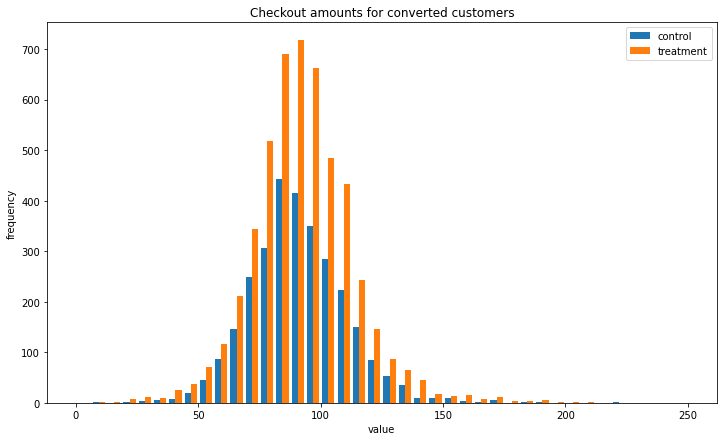

In [170]:
plt.figure(figsize=(12,7))
plt.hist([y_train_nt.to_numpy()[c_train_nt==1], y_train_t.to_numpy()[c_train_t==1]], label=['control', 'treatment'], bins=40, range=[0,250])
plt.legend(loc='upper right')
plt.title('Checkout amounts for converted customers')
plt.xlabel('value')
plt.ylabel('frequency')
plt.show()

In [ ]:
# ---- Benchmark Causal Model 1: Treated Customer Data

# -------- Hurdle Part 1: Conversion Logistic Regression Model

c_clas_t = LogisticRegression(solver='liblinear', random_state=42)
c_clas_t.fit(x_train_t, c_train_t)
c_pred_t = c_clas_t.predict_proba(x_train_t)[:,1]
c_pred_t_binary = c_clas_t.predict(x_train_t)
c_test_t_pred = c_clas_t.predict_proba(x_test_t)[:,1]
AUC_test_t = roc_auc_score(c_test_t, c_test_t_pred)

print(AUC_test_t)

# -------- Hurdle Part 2: Checkout Value Linear Regression Model

x_train_t_converted = x_train_t[c_train_t==1,]
y_train_t_converted = y_train_t[c_train_t==1]

y_regr_t = LinearRegression()
y_regr_t.fit(x_train_t_converted, y_train_t_converted)
y_pred_t = y_regr_t.predict(x_train_t_converted)
y_test_t_pred = y_regr_t.predict(x_test_t)
MSE_y_t = mean_squared_error(y_train_t_converted, y_pred_t)
MSE_y_test_t = mean_squared_error(y_test_t[c_test_t==1], y_test_t_pred[c_test_t==1])

print(MSE_y_test_t)

# -------- Hurdle Output: Expected Basket Value

basket_train_t = y_train_t
basket_pred_t = c_pred_t
basket_pred_t[c_train_t==1] = basket_pred_t[c_train_t==1]*y_pred_t
basket_pred_t[c_train_t==0] = 0

basket_test_t = y_test_t
basket_test_t_pred = c_test_t_pred*y_test_t_pred

MSE_basket_t = mean_squared_error(basket_train_t, basket_pred_t)
MSE_basket_test_t = mean_squared_error(basket_test_t, basket_test_t_pred)

print(MSE_basket_test_t)

0.6209622758790823
162.79695947818095
933.0360381590964


In [ ]:
# ---- Benchmark Causal Model 2: Control (Non-Treated) Customer Data

# -------- Hurdle Part 1: Conversion Logistic Regression Model

c_clas_nt = LogisticRegression(solver='liblinear', random_state=42)
c_clas_nt.fit(x_train_nt, c_train_nt)
c_pred_nt = c_clas_nt.predict_proba(x_train_nt)[:,1]
c_pred_nt_binary = c_clas_nt.predict(x_train_nt)
c_test_nt_pred = c_clas_nt.predict_proba(x_test_nt)[:,1]
AUC_test_nt = roc_auc_score(c_test_nt, c_test_nt_pred)

print(AUC_test_nt)

# -------- Hurdle Part 2: Checkout Value Linear Regression Model

x_train_nt_converted = x_train_nt[c_train_nt==1,]
y_train_nt_converted = y_train_nt[c_train_nt==1]

y_regr_nt = LinearRegression()
y_regr_nt.fit(x_train_nt_converted, y_train_nt_converted)
y_pred_nt = y_regr_nt.predict(x_train_nt_converted)
y_test_nt_pred = y_regr_nt.predict(x_test_nt)
MSE_y_nt = mean_squared_error(y_train_nt_converted, y_pred_nt)
MSE_y_test_nt = mean_squared_error(y_test_nt[c_test_nt==1], y_test_nt_pred[c_test_nt==1])

print(MSE_y_test_nt)

# -------- Hurdle Output: Expected Basket Value

basket_train_nt = y_train_nt
basket_pred_nt = c_pred_nt
basket_pred_nt[c_train_nt==1] = basket_pred_nt[c_train_nt==1]*y_pred_nt
basket_pred_nt[c_train_nt==0] = 0


basket_test_nt = y_test_nt
basket_test_nt_pred = c_test_nt_pred*y_test_nt_pred

MSE_basket_nt = mean_squared_error(basket_train_nt, basket_pred_nt)
MSE_basket_test_nt = mean_squared_error(basket_test_nt, basket_test_nt_pred)

print(MSE_basket_test_nt)

0.6981631176171825
325.2322156662036
566.0309446897079


In [ ]:
# ---- Benchmark Causal Models Output: Individual Treatment Effect

train_basket_treat = c_clas_t.predict_proba(x_train)[:,1] * y_regr_t.predict(x_train)
train_basket_control = c_clas_nt.predict_proba(x_train)[:,1] * y_regr_nt.predict(x_train)

basket_treat = c_clas_t.predict_proba(x_test)[:,1] * y_regr_t.predict(x_test)
basket_control = c_clas_nt.predict_proba(x_test)[:,1] * y_regr_nt.predict(x_test)

train_ITE_linear = train_basket_treat - train_basket_control
ITE_linear = basket_treat - basket_control

#plt.show(plt.hist(ITE_linear, bins = 100, range=(-20, 20)))

The baseline linear causal hurdle model is used to estimate the individual treatment effect for each customer. The distributions of the actual and estimated ITE values are displayed.


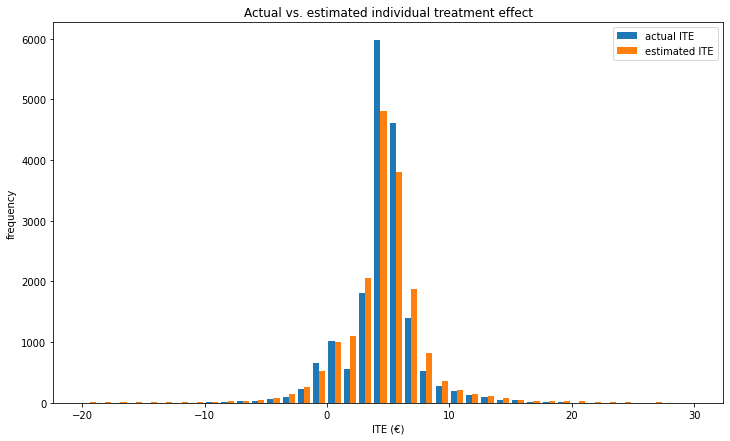

In [171]:
plt.figure(figsize=(12,7))
plt.hist([tau_response_test.to_numpy(),
          ITE_linear], label=['actual ITE', 'estimated ITE'], range=[-20,30], bins=40)
plt.legend(loc='upper right')
plt.title('Actual vs. estimated individual treatment effect')
plt.xlabel('ITE (€)')
plt.ylabel('frequency')
plt.show()

The performance metrics for the conversion, checkout amount and basket value estimation models for each of the treatment and control groups are indicated. Using the output from all of these models, ITE is calculated and evaluated with mean square error.

In [ ]:
baseline_causal_eval = pd.DataFrame(["conversion probability", "expected checkout amount", "expected basket value",
                              "conversion probability", "expected checkout amount", "expected basket value", "ITE"],
                             columns = ["target"])

baseline_causal_eval['customer group'] = ["control", "control", "control",
                          "treatment", "treatment", "treatment", "combined"]

baseline_causal_eval['model'] = ["logistic regression", "linear regression", "logistic+linear regression",
                          "logistic regression", "linear regression", "logistic+linear regression", "logistic+linear regression"]

baseline_causal_eval['metric_type'] = ["AUC", "MSE", "MSE", "AUC", "MSE", "MSE", "MSE"]
baseline_causal_eval['metric_result'] = [AUC_test_nt, MSE_y_test_nt, MSE_basket_test_nt, AUC_test_t,
                                         MSE_y_test_t, MSE_basket_test_t, mean_squared_error(tau_response_test, ITE_linear)]

baseline_causal_eval

,target,customer group,model,metric_type,metric_result
0,conversion probability,control,logistic regression,AUC,0.698163
1,expected checkout amount,control,linear regression,MSE,325.232216
2,expected basket value,control,logistic+linear regression,MSE,566.030945
3,conversion probability,treatment,logistic regression,AUC,0.620962
4,expected checkout amount,treatment,linear regression,MSE,162.796959
5,expected basket value,treatment,logistic+linear regression,MSE,933.036038
6,ITE,combined,logistic+linear regression,MSE,7.394658


# 8. Residual Model

Farrell et al. (2019) present an approach that allows estimation of customer spendings in a treated and a control group jointly using deep neural networks. This mean that we can incorporate our multitask nets very easily into this framework. They define sprendings of a treated customer $\mu_1$ as a sum of spendings of a customer without treatment $\mu_1$ and his individual treatment effect $\tau$, given features $x$:

\begin{equation}
\mu_1(x_i) = \mu_0(x_i) + \tau(x_i)
\end{equation}

Building upon the previous work of our peers (Alchahwan et al. (2020)), we implemented a residual model that consists of a multitask network predicting $\mu_0$, and a simple neural net that predicts $\tau$. The simple neural net is active only for those customers who received treatment. More formally the residual model prediction is calculated as:

\begin{equation}
\mu_1(x_i, T_i) = \mu_0(x_i) + T_i \times \tau(x_i)
\end{equation}

where $T$ is a treatment indicator. $\mu_0$ would then be the expected basket value predicted by the multitask network, independent of the treatment.

Since multitask networks enable simultaneous classification and regression, the residual model incorporating it can take advantage of that and consider treatment effect heterogeneity in our problem, described by Haupt and Lessmann (2020). Consequently we could be predicting not directly the total treatment effect on the expected basket value of a customer, but we could be separately predicting the treatment effect of a marketing campaign on customer conversion and the treatment effect on customer spending. We decided to test out both alternatives and see if the decomposition of the treatment effect estimates would result in more accurate estimates of the total treatment effect on the basket value.  

The multitask network arhcitecture that we incroporated into the residual model framework is *MTXNet* with DWA. Thus we built two residual models, first of which predicts both the treatment effect on conversion ($\tau_c$) and the treatment effect on customer spending ($\tau_y$). In addition to the solution proposed by Alchahwan et al. (2020) that ensures keeping the probability of a customer converting after adding the treatment effect in the range $[0;1]$ by putting it through sigmoid, we also tried out simply using value cuttoff for the conversion probabilities. I.e. if the sum of the predicted conversion probability were to be larger than 1 or smaller than 0, it would be simply be set 1 or 0 accordingly. Hence we arrive at two different loss functions for the first type of the residual model:

\begin{equation}
L(\theta_y, \theta_c) = \lambda_1 MSE[(y + T \times \tau_y)*sigm(c + T \times \tau_c), f(x; \theta_y, \theta_c)] + \lambda_2 wBCE[sigm(c + T \times \tau_c), f(x; \theta_c)]
\end{equation}

and 

\begin{equation}
L(\theta_y, \theta_c) = \lambda_1 MSE[(y + T \times \tau_y)*cut(c + T \times \tau_c), f(x; \theta_y, \theta_c)] + \lambda_2 wBCE[cut(c + T \times \tau_c), f(x; \theta_c)]
\end{equation}

The second residual model predicting a total treatment effect on the basket value ($\tau_v$) has a loss function defined as:

\begin{equation}
L(\theta_y, \theta_c) = \lambda_1 MSE((y \times c) + (T \times \tau_v), f(x; \theta_y, \theta_c)) + \lambda_2 wBCE(c, f(x; \theta_c))
\end{equation}

In [ ]:
# Create a weight tensor for weighted BCE
weight = len(c_train[c_train==0])/len(c_train)*10
w = np.ones(len(c_train))
w[c_train==1] = weight

set_seed()

#data prep for the Resiudal Model
data_train_residual = TreatedWeightedExperimentData(torch.from_numpy(x_train).float().to(device), 
                                           torch.from_numpy(y_train.values).float().to(device), 
                                           torch.from_numpy(c_train.values).float().to(device), 
                                           torch.from_numpy(w).float().to(device), 
                                           torch.from_numpy(g_train.values).float().to(device))

data_val_residual = WeightedExperimentData(torch.from_numpy(x_val).float().to(device), 
                                  torch.from_numpy(y_val.values).float().to(device), 
                                  torch.from_numpy(c_val.values).float().to(device), 
                                  torch.from_numpy(g_val.values).float().to(device))

data_test_residual = WeightedExperimentData(torch.from_numpy(x_test).float(), 
                                   torch.from_numpy(y_test.values).float(),
                                   torch.from_numpy(c_test.values).float(),
                                   torch.from_numpy(g_test.values).float())

res_val_loader = DataLoader(data_val_residual, batch_size = len(data_val_residual))
res_test_loader = DataLoader(data_test_residual, batch_size = len(data_test_residual))

# 8.1 Implementation

The implementation of the first residual model type is shown below. We test out 6 different configuration of an axuiliary multitask network that simulataneously predicts two treatment effects - $\tau_c$ and $\tau_y$ on both solutions for keeping predicted conversion probabilities in a proper range. The auxiliary multitask ITE NN has the same structure as *MTNet*. The main *MTXNet* has the hyperparameters that was best for the DWA approach from last section.

In [ ]:
# Auxiliary multitask network predcting treatment effects on conversion and spending simultaneously
class MTIte(MTNet):
  def __init__(self, input_dim, joint_layer_size, disjoint_layer_size, criterion, drop):

    super().__init__(input_dim, joint_layer_size, disjoint_layer_size, criterion, criterion, drop, weighted=False)

    self.criterion = criterion
    self.output_c = nn.Linear(self.disjoint_layer_sizes[-1], 1)

In [ ]:
# Corresponding residual model that considers heterogeneity in treatment effects
class MTResidualModelBase(nn.Module):
  def __init__(self, mt_model, ite_model, criterion_y, criterion_c, sigm):
    super().__init__()
    self.mt_model = mt_model
    self.ite_model = ite_model
    self.optimizer = None
    self.criterion_y = criterion_y
    self.criterion_c = criterion_c
    self.sigm = sigm

  def forward(self, x, T):
    mt_output = self.mt_model(x)
    ite_pred = self.ite_model(x)
    # Either put conversion probabilities through sigmoid or simply set out of range values
    # to boundary values
    if self.sigm == True:
      conv = torch.sigmoid(mt_output[0] + (T * ite_pred[0]))
    else:
      conv = mt_output[0] + (T * ite_pred[0])
      conv[conv>1] = 1
      conv[conv<0] = 0
    checkout = mt_output[2] + (T * ite_pred[1])
    exp_basket = conv*checkout
    return mt_output, ite_pred, conv, checkout, exp_basket

In [ ]:
# Inheriting from a class that was used for display purposes for the blogpost format
class MTResidualModel(MTResidualModelBase):
  def __init__(self, mt_model, ite_model, criterion_y, criterion_c, sigm):
    super().__init__(mt_model, ite_model, criterion_y, criterion_c, sigm)

    #for compatibility with daw_fit function
    self.joint_layer_size = self.ite_model.joint_layer_size
    self.disjoint_layer_size = self.ite_model.disjoint_layer_size
    self.drop = self.ite_model.drop
    self.weighted=sigm

  def train_iteration(self, lambda1, lambda2, data_loader):
    running_loss = 0.0
    train_loss_mse = 0.0
    train_loss_bce = 0.0
    c_true=[]
    c_pred=[]
    for i, (X,y,c,w,g) in enumerate(data_loader):

      _,_,conv,_,exp_basket = self(X, g.unsqueeze(1))

      c_pred.extend(conv.squeeze())
      c_true.extend(c)

      loss1 = self.criterion_y(exp_basket.squeeze(), y)

      if self.weighted == True:
        weighted_criterion = nn.BCELoss(weight = w)
        loss2 = weighted_criterion(conv.squeeze(), c)
      else:
        loss2 = self.criterion_c(conv.squeeze(), c)
      
      loss = lambda1*loss1 + lambda2*loss2

      self.optimizer.zero_grad()        
      loss.backward()
      self.optimizer.step()
      
      loss = loss1 + loss2
      
      running_loss += loss.item()
      train_loss_mse += loss1.item()
      train_loss_bce += loss2.item()

    n_batches = int(np.ceil(len(data_loader.dataset)/data_loader.batch_size))
    running_loss = running_loss/n_batches
    train_loss_mse = train_loss_mse/n_batches
    train_loss_bce = train_loss_bce/n_batches
    #for compatibility with the daw_fit function
    bv_train_mse = train_loss_mse

    train_auc = roc_auc_score(torch.Tensor(c_true), torch.Tensor(c_pred))

    return running_loss, train_auc, train_loss_mse, train_loss_bce, bv_train_mse

  def val_iteration(self, data_loader):
    val_loss = 0.0
    val_loss_mse = 0.0
    val_loss_bce = 0.0
    c_true_val=[]
    c_pred_val=[]
    with torch.no_grad():
      for i, (X_val,y_val,c_val,g_val) in enumerate(data_loader):

        _,_,conv_val,_,exp_basket_val = self(X_val, g_val.unsqueeze(1))
        c_pred_val.extend(conv_val.squeeze())
        c_true_val.extend(c_val)
        loss1 = self.criterion_y(exp_basket_val.squeeze(), y_val)
        loss2 = self.criterion_c(conv_val.squeeze(), c_val)
        loss = loss1 + loss2
        val_loss += loss.item()
        val_loss_mse += loss1.item()
        val_loss_bce += loss2.item()
        bv_val_mse = val_loss_mse

      val_auc = roc_auc_score(torch.Tensor(c_true_val), torch.Tensor(c_pred_val))

    return val_loss, val_auc, val_loss_mse, val_loss_bce, bv_val_mse

In [ ]:
def mt_residual_tune(ite_joint, ite_disjoint, drop, epochs, temp, path):

  results = []
  set_seed()
  mt_ite_model = MTIte(61, ite_joint, ite_disjoint, mse_loss, drop).to(device)

  set_seed()
  mt_residual_model_cutoff = MTResidualModel(mt_daw_model, mt_ite_model, mse_loss, bce_loss, sigm = False).to(device)
  mt_residual_model_cutoff.optimizer = optim.Adam(mt_residual_model_cutoff.parameters(), lr=0.001)

  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss, net_min_bv_epoch,
   net_min_bv_auc, net_min_bv_total_loss, net_history) = daw_fit(path = path, model = mt_residual_model_cutoff, 
                                                                 train_loader = res_train_loader, epochs = epochs, 
                                                                 val_loader = res_val_loader, temp = temp,
                                                                 th_auc=0.64, th_loss=771, th_stop=19)
  net_history.to_csv(dir_path + '%s/training_history/%s_%s_%d_%d_%.1f.csv' % 
                     (path, mt_residual_model_cutoff.__class__.__name__, mt_residual_model_cutoff.sigm,
                      ite_joint, ite_disjoint, drop))
  results.append([mt_residual_model_cutoff.__class__.__name__, mt_residual_model_cutoff.sigm, ite_joint,
                  ite_disjoint, net_max_auc_epoch, net_max_auc, net_max_auc_loss, net_max_auc_bv_loss, 
                  net_min_bv_loss, net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss])

  set_seed()
  mt_residual_model_sigm = MTResidualModel(mt_daw_model, mt_ite_model, mse_loss, bce_loss, sigm = True).to(device)
  mt_residual_model_sigm.optimizer = optim.Adam(mt_residual_model_sigm.parameters(), lr=0.001)

  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss, net_min_bv_epoch,
   net_min_bv_auc, net_min_bv_total_loss, net_history) = daw_fit(path = path, model = mt_residual_model_sigm,
                                                                 train_loader = res_train_loader, epochs = epochs,
                                                                 val_loader = res_val_loader, temp = temp,
                                                                 th_auc=0.64, th_loss=771, th_stop=19)
  net_history.to_csv(dir_path + '%s/training_history/%s_%s_%d_%d_%.1f.csv' % 
                     (path, mt_residual_model_sigm.__class__.__name__, mt_residual_model_sigm.sigm,
                      ite_joint, ite_disjoint, drop))
  results.append([mt_residual_model_sigm.__class__.__name__, mt_residual_model_sigm.sigm, ite_joint, 
                  ite_disjoint, net_max_auc_epoch, net_max_auc, net_max_auc_loss, net_max_auc_bv_loss, 
                  net_min_bv_loss, net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss])

  return results

In [ ]:
param_grid = {'joint_dim' : [128, 256, 512], 'disjoint_dim' : [64, 128, 256], 'drop' : [0.1, 0.2, 0.3, 0.4]}
keys, values = zip(*param_grid.items())
paramlist = list(itertools.product(*values))
set_seed()
grid_sample = random.sample(paramlist, 6)
grid_sample

[(128, 64, 0.4),
 (128, 128, 0.2),
 (512, 256, 0.3),
 (256, 256, 0.4),
 (128, 256, 0.3),
 (512, 256, 0.1)]

In [ ]:
# Tuning Multitask Residual Model
set_seed()
res_train_loader = DataLoader(data_train_residual, 512, shuffle = True)
mt_daw_model = DAW_MTXNet(61, 128, 64, mse_loss, bce_loss, 0.4, weighted = True).to(device)

results = []
for paramset in grid_sample:
  mt_residual_results = mt_residual_tune(paramset[0], paramset[1], paramset[2], 125, 0.05, 'residual_model')
  results.extend(mt_residual_results)

results = np.array(results)
np.save(dir_path + 'residual_model/mt_residual_results.npy', results)

print('MT Residual training completed!')

In [ ]:
#result summary
mt_residual_results = np.load(dir_path + 'residual_model/mt_residual_results.npy', allow_pickle=True)
cols = ['type', 'sigmoid', 'joint_dim', 'disjoint_dim', 'dropout', 'max_val_auc_epoch', 
        'max_val_auc', 'max_val_auc_loss', 'max_val_auc_bv_loss', 'min_val_bv_loss', 
        'min_bv_epoch', 'min_bv_auc', 'min_bv_total_loss']
top_mt_residual = pd.DataFrame(mt_residual_results, columns = cols)
top_mt_residual.sort_values(by=['min_val_bv_loss'], ascending=True).head(5)

,type,sigmoid,joint_dim,disjoint_dim,dropout,max_val_auc_epoch,max_val_auc,max_val_auc_loss,max_val_auc_bv_loss,min_val_bv_loss,min_bv_epoch,min_bv_auc,min_bv_total_loss
0,MTResidualModel,False,128,64,0.4,50,0.6689904854243329,767.4232177734375,757.3714599609375,753.0348510742188,105,0.6425869746760096,756.9130249023438
2,MTResidualModel,False,128,128,0.2,95,0.6621641716737324,769.2952880859375,766.8800659179688,755.1573486328125,44,0.6226281698596325,761.37255859375
1,MTResidualModel,True,128,64,0.4,4,0.6414405340837814,760.6431274414062,759.506591796875,755.1593627929688,21,0.6226419972832111,756.4696655273438
4,MTResidualModel,False,512,256,0.3,68,0.6069994018412823,820.7691650390625,776.098876953125,759.9069213867188,21,0.6020885950828883,804.7005004882812
7,MTResidualModel,True,256,256,0.4,2,0.6537251551542311,770.47265625,769.5875854492188,765.79052734375,56,0.6173528351487656,766.5659790039062


In [ ]:
#evaluation here
net1 = DAW_MTXNet(61, 128, 64, mse_loss, bce_loss, 0.4, weighted = True)
net2 = MTIte(61, 128, 64, mse_loss, 0.4)
mt_residual= MTResidualModel(net1, net2, mse_loss, bce_loss, sigm = True)
state_residual = torch.load(dir_path+'residual_model/models/model_MTResidualModel_False_128_64_0.4_0.05_105_0.6426_756.9130_753.0349.tar', 
                   map_location=torch.device('cpu'))
mt_residual.load_state_dict(state_residual['model_state_dict'])

with torch.no_grad():
  mt_residual.eval()
  mtres_output, mtres_ite_pred, mtres_conv, mtres_checkout, mtres_exp_basket = mt_residual(data_test_residual.X, data_test_residual.w.unsqueeze(1))

mtres_response_ite = (mtres_exp_basket - mtres_output[1]).squeeze()

The residual model pridcting $\tau_r$ uses a regular feedforward neural net with 3 hidden layers and no dropout as an auxiliary model. 7 different configurations of the auxiliary model were tested.

In [ ]:
# Auxiliary NN predicting the treatment effect on basket value

class IteNN(CheckoutNN):

  def __init__(self, input_dim, hidden_layers, criterion):

    super().__init__(input_dim, hidden_layers, criterion)

In [ ]:
# Residual model that considers only the homogeneous total treatment effect on the expected basket value

class ResponseResidualModelBase(nn.Module):
  def __init__(self, mt_model, ite_model, criterion_y, criterion_c):
    super().__init__()
    self.mt_model = mt_model
    self.ite_model = ite_model
    self.optimizer = None
    self.criterion_y = criterion_y
    self.criterion_c = criterion_c

  def forward(self, x, T):
    mt_output = self.mt_model(x)
    ite_pred = self.ite_model(x)
    basket = mt_output[1] + (T * ite_pred)
    return basket, mt_output, ite_pred

In [ ]:
# Inheriting from a class that was used for display purposes for the blogpost format
class ResponseResidualModel(ResponseResidualModelBase):
  def __init__(self, mt_model, ite_model, criterion_y, criterion_c):
    super().__init__(mt_model, ite_model, criterion_y, criterion_c)
    self.weighted = mt_model.weighted

  def train_iteration(self, lambda1, lambda2, data_loader):
    running_loss = 0.0
    train_loss_mse = 0.0
    train_loss_bce = 0.0
    c_true=[]
    c_pred=[]
    for i, (X,y,c,w,g) in enumerate(data_loader):

      cy_hat,mt_outp,_ = self(X, g.unsqueeze(1))

      c_pred.extend(mt_outp[0].squeeze())
      c_true.extend(c)

      loss1 = self.criterion_y(cy_hat.squeeze(), y)

      if self.weighted == True:
        weighted_criterion = nn.BCELoss(weight = w)
        loss2 = weighted_criterion(mt_outp[0].squeeze(), c)
      else:
        loss2 = self.criterion_c(mt_outp[0].squeeze(), c)
      
      loss = lambda1*loss1 + lambda2*loss2

      self.optimizer.zero_grad()        
      loss.backward()
      self.optimizer.step()
      
      loss = loss1 + loss2
      
      running_loss += loss.item()
      train_loss_mse += loss1.item()
      train_loss_bce += loss2.item()

    n_batches = int(np.ceil(len(data_loader.dataset)/data_loader.batch_size))
    running_loss = running_loss/n_batches
    train_loss_mse = train_loss_mse/n_batches
    train_loss_bce = train_loss_bce/n_batches
    #for compatibility with the daw_fit function
    bv_train_mse = train_loss_mse

    train_auc = roc_auc_score(torch.Tensor(c_true), torch.Tensor(c_pred))

    return running_loss, train_auc, train_loss_mse, train_loss_bce, bv_train_mse

  def val_iteration(self, data_loader):
    val_loss = 0.0
    val_loss_mse = 0.0
    val_loss_bce = 0.0
    c_true_val=[]
    c_pred_val=[]
    with torch.no_grad():
      for i, (X_val,y_val,c_val,g_val) in enumerate(data_loader):

        cy_hat_val,mt_outp_val,_ = self(X_val, g_val.unsqueeze(1))
        c_pred_val.extend(mt_outp_val[0].squeeze())
        c_true_val.extend(c_val)
        loss1 = self.criterion_y(cy_hat_val.squeeze(), y_val)
        loss2 = self.criterion_c(mt_outp_val[0].squeeze(), c_val)
        loss = loss1 + loss2
        val_loss += loss.item()
        val_loss_mse += loss1.item()
        val_loss_bce += loss2.item()
        bv_val_mse = val_loss_mse

      val_auc = roc_auc_score(torch.Tensor(c_true_val), torch.Tensor(c_pred_val))

    return val_loss, val_auc, val_loss_mse, val_loss_bce, bv_val_mse

  def fit(self, path, train_loader, epochs, val_loader, temp):
    val_auc_list = []
    val_bv_loss_list = []
    cols = ['epoch', 'train_loss', 'basket_value_train_loss', 'train_auc', 'train_mse', 'train_bce',
            'val_loss', 'basket_value_val_loss', 'val_auc', 'val_mse', 'val_bce', 'lambda1', 'lambda2']
    history = pd.DataFrame(columns = cols, index = range(epochs))
    lambda1 = 1
    lambda2 = 1
    T = torch.tensor([temp], dtype=float, device=device, requires_grad=False)
    train_mse_prev = 0
    train_bce_prev = 0
    for epoch in range(epochs):
      self.train()
      running_loss, train_auc, train_mse, train_bce, train_bv_loss = self.train_iteration(lambda1, lambda2, train_loader)
      self.eval()
      val_loss, val_auc, val_mse, val_bce, val_bv_loss = self.val_iteration(val_loader)
      
      if epoch>1:
          print("Loss Y: ", train_mse, " Loss Y_prev: ", train_mse_prev)
          print("Loss C: ", train_bce, " Loss C_prev: ", train_bce_prev)
          w1 = train_mse/train_mse_prev
          w2 = train_bce/train_bce_prev
          try:
            lambda1 = 2*math.exp(w1/T)/(math.exp(w1/T)+math.exp(w2/T))
            lambda2 = 2*math.exp(w2/T)/(math.exp(w1/T)+math.exp(w2/T))
          except OverflowError:
            lambda1 = 1
            lambda2 = 1

      print("Lambda1: ", lambda1, " - Lambda2: ", lambda2)
      
      train_mse_prev = train_mse
      train_bce_prev = train_bce

      #print out training information
      print('[%d] loss: %.4f | bv train loss: %.4f | validation loss: %.4f | bv val loss: %.4f | auc: %.4f | val_auc: %.4f' % 
            (epoch+1, running_loss, train_bv_loss, val_loss, val_bv_loss, train_auc, val_auc))
      #save good performing models
      if val_auc>0.64:
        if len(val_auc_list)>1 and val_auc>max(val_auc_list):
          torch.save({'model_state_dict': self.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()},
              "/content/drive/My Drive/apa/%s/models/model_%s_%s_%s_%d_%.4f_%.4f_%.4f.tar" % 
              (path, self.__class__.__name__, self.weighted, self.ite_model.hidden_layer_sizes[1:],
              epoch+1, val_auc, val_loss, val_bv_loss))
      #also add saving based on bv loss
      if val_bv_loss<761: 
        if len(val_bv_loss_list)>1 and val_bv_loss<min(val_bv_loss_list):
          torch.save({'model_state_dict': self.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()},
              "/content/drive/My Drive/apa/%s/models/model_%s_%s_%s_%d_%.4f_%.4f_%.4f.tar" % 
              (path, self.__class__.__name__, self.weighted, self.ite_model.hidden_layer_sizes[1:],
              epoch+1, val_auc, val_loss, val_bv_loss))
      val_auc_list.append(val_auc)
      val_bv_loss_list.append(val_bv_loss)
      values = [epoch+1, running_loss, train_bv_loss, train_auc, train_mse, train_bce, val_loss, val_bv_loss,
                val_auc, val_mse, val_bce, lambda1, lambda2]
      history.iloc[epoch] = values
      #'early stopping'
      if len(val_auc_list)>19 and all(i < 0.52 for i in val_auc_list[-19:]):
        break

    history[cols] = history[cols].apply(pd.to_numeric, errors = 'ignore')

    max_auc = max(history['val_auc'])
    max_auc_loss = history['val_loss'][history['val_auc'].argmax()]
    max_auc_epoch = history['epoch'][history['val_auc'].argmax()]
    max_auc_bv_loss = history['basket_value_val_loss'][history['val_auc'].argmax()]

    min_val_bv_loss = min(history['basket_value_val_loss'])
    min_val_bv_epoch = history['epoch'][history['basket_value_val_loss'].argmin()]
    min_val_bv_auc = history['val_auc'][history['basket_value_val_loss'].argmin()]
    min_val_bv_yloss = history['val_loss'][history['basket_value_val_loss'].argmin()]

    return (max_auc, max_auc_loss, max_auc_epoch, max_auc_bv_loss, min_val_bv_loss, min_val_bv_epoch,
          min_val_bv_auc, min_val_bv_yloss, history)

In [ ]:
def response_residual_tune(mt_model, hidden_layers, path):

  set_seed()
  ite_model = IteNN(61, hidden_layers, mse_loss)
  set_seed()
  net = ResponseResidualModel(mt_model, ite_model, mse_loss, bce_loss).to(device)
  net.optimizer = optim.Adam(net.parameters(), lr=0.001)

  (net_max_auc, net_max_auc_loss, net_max_auc_epoch, net_max_auc_bv_loss, net_min_bv_loss,
   net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss, net_history) = net.fit(path = path,
                                                                                   train_loader = res_train_loader,
                                                                                   epochs = 150, 
                                                                                   val_loader = res_val_loader, 
                                                                                   temp = 0.05)
  net_history.to_csv(dir_path + '%s/training_history/%s_%s.csv' % 
                     (path, net.__class__.__name__, hidden_layers))
  res = [net.__class__.__name__, net.weighted, hidden_layers, net_max_auc_epoch, net_max_auc, net_max_auc_loss,
         net_max_auc_bv_loss, net_min_bv_loss, net_min_bv_epoch, net_min_bv_auc, net_min_bv_total_loss]

  return res

In [ ]:
# Train the ResponseResidualModel 
# TESLA K80 was used for tuning/training this model
set_seed()
res_train_loader = DataLoader(data_train_residual, 512, shuffle = True)
set_seed()
mt_daw_model = DAW_MTXNet(61, 128, 64, mse_loss, bce_loss, 0.4, weighted = True).to(device)

residual_response_results = []
hidden_set = [[1024, 512, 256], [512, 256, 128], [256, 128, 64], [1024, 512], [512, 256], [256, 128], [128,64]]

for hidden in hidden_set:
  results = response_residual_tune(mt_daw_model, hidden, 'residual_model')
  residual_response_results.append(results)

residual_response_results = np.array(residual_response_results)
np.save(dir_path + 'residual_model/residual_response_results.npy', residual_response_results)

print('Residual Model training completed!')

In [ ]:
#result summary
response_residual_results = np.load(dir_path + 'residual_model/residual_response_results.npy', allow_pickle=True)
cols = ['type', 'weighted', 'hidden', 'max_val_auc_epoch', 'max_val_auc', 'max_val_auc_loss', 
        'max_val_auc_bv_loss', 'min_val_bv_loss', 'min_bv_epoch', 'min_bv_auc', 'min_bv_total_loss']
top_response_residual = pd.DataFrame(response_residual_results, columns = cols)
top_response_residual

,type,weighted,hidden,max_val_auc_epoch,max_val_auc,max_val_auc_loss,max_val_auc_bv_loss,min_val_bv_loss,min_bv_epoch,min_bv_auc,min_bv_total_loss
0,MTResidualModel,True,"[1024, 512, 256]",101,0.6489895623847564,865.2175903320312,864.3049926757812,772.5258178710938,44,0.6335626456785395,774.3021240234375
1,MTResidualModel,True,"[512, 256, 128]",23,0.6550536780219915,760.428466796875,757.3084716796875,757.0164794921875,9,0.652442402693822,759.4412231445312
2,MTResidualModel,True,"[256, 128, 64]",9,0.6596621348088398,761.6091918945312,759.609130859375,754.2115478515625,15,0.6438986175483632,757.3743896484375
3,MTResidualModel,True,"[1024, 512]",78,0.6412021427600627,6713.216796875,6709.400390625,764.5639038085938,127,0.6238439292704572,769.1919555664062
4,MTResidualModel,True,"[512, 256]",5,0.628279661368032,1631.1494140625,1626.9515380859375,760.37353515625,34,0.6105255220442928,762.0813598632812
5,MTResidualModel,True,"[256, 128]",4,0.599817935894538,4429.6416015625,4428.794921875,762.9412231445312,40,0.5667235511004158,763.6060180664062
6,MTResidualModel,True,"[128,64]",119,0.5687435359974531,776.4381103515625,775.7911987304688,763.4535522460938,59,0.5615170809563853,764.0540161132812


In [ ]:
#evaluation here

net1 = DAW_MTXNet(61, 128, 64, mse_loss, bce_loss, 0.4, weighted = True)
net2 = IteNN(61, [256,128,64], mse_loss)
reponse_residual = ResponseResidualModel(net1, net2, mse_loss, bce_loss)
state_rm = torch.load(dir_path+'residual_model/models/model_MTResidualModel_True_[256, 128, 64]_15_0.6439_757.3744_754.2115.tar',
                   map_location=torch.device('cpu'))
reponse_residual.load_state_dict(state_rm['model_state_dict'])

with torch.no_grad():
  reponse_residual.eval()
  basket_response, mt_output_response, ite_pred_response = reponse_residual(data_test_residual.X, data_test_residual.w.unsqueeze(1))

The results of the best configurations of both types of the residual model on the test set leave a great deal to be desired. The results of the residual model are 2-3 times worse in terms of the MSE of predicted ITE on basket value, compared to the linear causal hurdle two-model approach. The predicted basket value MSE remained essentially the same, while the conversion AUC deteriorated, compared to a non-causal *MTXNet* with DWA. 

In [ ]:
residual_eval = pd.DataFrame(["MTResidualModel", "ResponseResidualModel"],
                             columns = ["Model Type"])

residual_eval['Basket value MSE'] = [mean_squared_error(mtres_exp_basket, y_test), mean_squared_error(basket_response, y_test)]
residual_eval['Conversion AUC'] = [roc_auc_score(c_test, mtres_conv), roc_auc_score(c_test, mt_output_response[0])]
residual_eval['Basket Value ITE MSE'] = [mean_squared_error(mtres_response_ite, tau_response_test), mean_squared_error(ite_pred_response, tau_response_test)]

residual_eval

,Model Type,Basket value MSE,Conversion AUC,Basket Value ITE MSE
0,MTResidualModel,758.917995,0.619480,21.873878
1,ResponseResidualModel,757.843697,0.615951,15.267882


A closer look at the distributions of the predicted ITE values emphasize even more how poor the residual models were able to depict the "true" ITEs, known from simulations. On the contrast, linear causal hurdle two-model approach showed a very close fit to the "true" distribution of the treatment effect on basket value.

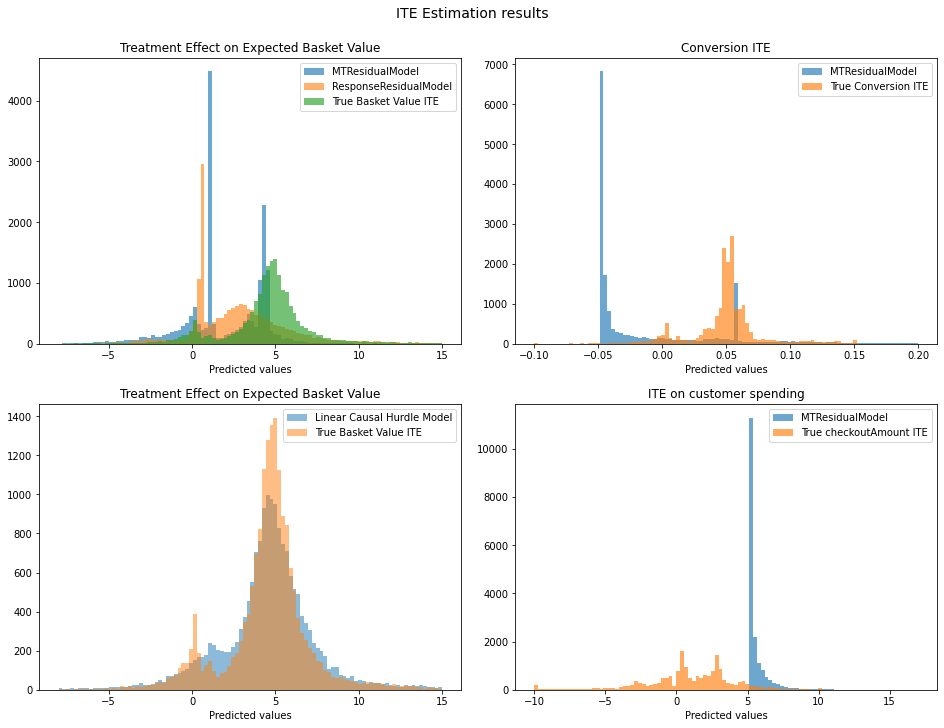

In [ ]:
f, axarr = plt.subplots(2, 2, constrained_layout=True)
# Plot predicted ITEs on Basket Value by both residual models vs the "true" one
axarr[0][0].hist(mtres_response_ite.numpy(), bins = 100, alpha = 0.65, range=(-8, 15), label = 'MTResidualModel')
axarr[0][0].hist(ite_pred_response.squeeze().detach().numpy(), bins = 100, alpha = 0.6, range=(-8, 15), label = 'ResponseResidualModel')
axarr[0][0].hist(tau_response_test, bins = 100, alpha = 0.65, range=(-8, 15), label = 'True Basket Value ITE')
axarr[0][0].legend()
axarr[0][0].set_title('Treatment Effect on Expected Basket Value')
axarr[0][0].set_xlabel('Predicted values')
# Plot predicted ITEs on Basket Value by the linear causal hurdle model vs the "true" one
axarr[1][0].hist(ITE_linear, bins = 100, alpha = 0.5, range=(-8, 15), label = 'Linear Causal Hurdle Model')
axarr[1][0].hist(tau_response_test, bins = 100, alpha = 0.5, range=(-8, 15), label = 'True Basket Value ITE')
axarr[1][0].legend()
axarr[1][0].set_title('Treatment Effect on Expected Basket Value')
axarr[1][0].set_xlabel('Predicted values')
axarr[0][1].hist(mtres_ite_pred[0].squeeze().numpy(), bins = 100, alpha = 0.65, range=(-0.1, 0.2), label = 'MTResidualModel')
axarr[0][1].hist(tau_conversion_test, bins = 100, range=(-0.1, 0.2), alpha = 0.65, label = 'True Conversion ITE')
axarr[0][1].set_title('Conversion ITE')
axarr[0][1].set_xlabel('Predicted values')
axarr[0][1].legend()
axarr[1][1].hist(mtres_ite_pred[1].squeeze().numpy(), bins = 100, alpha = 0.65, range=(-10, 17), label = 'MTResidualModel')
axarr[1][1].hist(tau_basket_test, bins = 100, alpha = 0.65, range=(-10, 17), label = 'True checkoutAmount ITE')
axarr[1][1].set_title('ITE on customer spending')
axarr[1][1].set_xlabel('Predicted values')
axarr[1][1].legend(loc = 'upper right')
f.suptitle('ITE Estimation results', fontsize=14)
f.set_size_inches(13,10)
plt.show()

Further comparing the CATE estimates based on the transformed outcome loss (TOL), root mean squared error (RMSE) and mean absolute error (MAE) similarly to Haupt and Lessmann (2020), we see the same picture - meaning that the residual model get significantly outperformed by the linear causal hurdle model.

In [ ]:
# Create a dictionary with predicted ITE values and conversion probabilities
predictions_test = {"treatment_spending": {"MTResidual": mtres_response_ite.numpy(), "ResponseResidual": ite_pred_response.squeeze().numpy(), "Linear Two-Model": ITE_linear, "True ITE": tau_response_test},
                    "conversion": {"MTResidual": mtres_conv.squeeze().numpy(), "ResponseResidual": mt_output_response[0].squeeze().numpy(), "Linear Two-Model": c_test_pred_linear}}

In [ ]:
# Quality of model estimates for the CATE

eval_test = [calc_prediction_error(predictions_test["treatment_spending"],
                                   y_test, g_test, tau_true=tau_response_test)]
eval_test_dataframe = pd.concat([pd.DataFrame(x) for x in eval_test], axis=0, keys=range(len(eval_test)))
eval_test_dataframe.index.rename(["fold","Model"], inplace=True)
eval_precision = eval_test_dataframe.groupby("Model").mean().T
eval_precision = eval_precision.rename(mapper={"transformed_outcome_loss": "TOL", 
                                               "root_mean_squared_error": "RMSE", 
                                               "mean_absolute_error": "MAE"}, axis=1)
eval_precision

Model,TOL,RMSE,MAE
MTResidual,3334.277705,4.676952,3.566905
ResponseResidual,3396.287117,3.907414,2.884520
Linear Two-Model,3386.654430,2.719312,1.421903
True ITE,3382.939851,0.000000,0.000000


Despite how poor the residual models performed with respect to CATE estimates, it would be still interesting to see what profit implications all three causal models have, based on their predictions.

# 9. Profit implications

In [ ]:
# The margin ratio value is based on Johannes's Haupt notebook: 
# https://github.com/johaupt/response-dependent-costs/blob/master/evaluate_treatment_models.ipynb
MARGIN_RATIO = 0.3
OFFER_COST = 10
CONTACT_COST = 0

In [ ]:
# Determine who to target, using the analytical targeting policy
linear_targeting = bayesian_targeting_policy(ITE_linear*MARGIN_RATIO, CONTACT_COST, c_test_pred_linear, OFFER_COST)
mt_residual_targeting = bayesian_targeting_policy(mtres_response_ite.squeeze().numpy()*MARGIN_RATIO, CONTACT_COST, mtres_conv.squeeze().numpy(), OFFER_COST)
response_residual_targeting = bayesian_targeting_policy(ite_pred_response.squeeze().numpy()*MARGIN_RATIO, CONTACT_COST, mt_output_response[0].squeeze().numpy(), OFFER_COST)
treat_all = np.ones(ITE_linear.shape[0], dtype="int")
treat_none = np.zeros(ITE_linear.shape[0], dtype="int")

# Calculation the fraction of the customers who are going to be treated
fraction_targeted_linear = len(linear_targeting[linear_targeting == 1])/len(linear_targeting)
fraction_targeted_mt_residual = len(mt_residual_targeting[mt_residual_targeting == 1])/len(mt_residual_targeting)
fraction_targeted_response_residual = len(response_residual_targeting[response_residual_targeting == 1])/len(response_residual_targeting)
all_treated = 1
none_treated = 0

# Calculate profit from resulting targeting policy
linear_profit = expected_policy_profit(linear_targeting, g_test, (y_test*MARGIN_RATIO - (OFFER_COST*linear_targeting*c_test)), g_test.mean())
mt_residual_profit = expected_policy_profit(mt_residual_targeting, g_test, (y_test*MARGIN_RATIO - (OFFER_COST*mt_residual_targeting*c_test)), g_test.mean())
response_residual_profit = expected_policy_profit(response_residual_targeting, g_test, (y_test*MARGIN_RATIO - (OFFER_COST*response_residual_targeting*c_test)), g_test.mean())
all_profit = expected_policy_profit(treat_all, g_test, (y_test*MARGIN_RATIO - (OFFER_COST*treat_all*c_test)), g_test.mean())
none_profit = expected_policy_profit(treat_none, g_test, (y_test*MARGIN_RATIO - (OFFER_COST*treat_none*c_test)), g_test.mean())

Calculating the expected profit based on the analytical targeting policy introduced by Haupt and Lessmann (2020), we see that the residual models can't even outperform a naive policy of targeting no customers at all, which is pretty disappointing. The predictions of these models are unreliable, since one of the models essentially suggests to target less than one percent of the customers in the test set, while the other makes predictions that result in a naive targeting of no customers.

In [ ]:
# Summary in a table
profit = pd.DataFrame(["Treat all", "Linear Two-Model", "MTResidual", "ResponseResidual", "Treat none"],
                             columns = ["Model"])

profit['Profit'] = [all_profit, linear_profit, mt_residual_profit, response_residual_profit, none_profit]
profit['Fraction Treated'] = [all_treated, fraction_targeted_linear, fraction_targeted_mt_residual, fraction_targeted_response_residual, none_treated]

profit

,Model,Profit,Fraction Treated
0,Treat all,38229.895058,1.000000
1,Linear Two-Model,42717.479752,0.773984
2,MTResidual,34682.864379,0.000056
3,ResponseResidual,34815.614025,0.002299
4,Treat none,34682.864379,0.000000


# 10. Conclusion

In order to fulfill the objective of this paper, which is to implement a single sophisticated neural network structure that follows the cost-depending causal approach as suggested by Haupt and Lessmann (2020), different multitask architectures and a residual model were built. The multitask neural network frameworks that simultaneously carry out classification and regression tasks to predict the expected basket value are shown to be unsuccessful in making accurate predictions. The multitask models are not able to outperform the baseline models that consist of linear and logistic regression and simple neural networks that each focus on one of the tasks. In order to develop the multitask models, dynamic adaptive weights and separate learning rates approaches are added. As a result, the former increased the performance of the model to some degree, while the latter has made no difference.

The residual model in the second part that involves individual treatment effect estimation does not outperform the benchmark two-part causal linear model either. The performance of the multitask neural networks and the residual model shows that the suggested architectures may not be suitable for the given marketing campaign targeting decision-making. The models implemented in this paper are not successful at identifying the underlying hurdle nature of the conversion and checkout amount targets. It could be more promising to take the research further by trying completely different architectures. Given that the baseline models outperform the sophisticated architectures indicates that complex deep learning models do not necessarily perform better than simple models.

It is a good idea to try completely new architectures that can potentially identify the underlying hurdle nature of the two targets. Abraham and Tan (2010) introduce a new approach to accurately predict values of zero-inflated data. The suggested integrated framework simultaneously performs classification and regression tasks, and involves the output of one model being fed as an input into the other model. This can indicate that the regression output is added as an additional node to one of the layers in the neural network to predict the classification output. The vice versa can also be implement, and the direction of the merge that provides more accurate results can be chosen. It must also be noted that, in the Abraham and Tan (2010) approach to the multitask problem, the regression and classification models are trained simultaneously to perform well on the joint objective function, which is a combination of the two error functions. The model proves to be effective for climate and precipitation data, which is also heavily zero-inflated, and can be a promising further step for research in analytical targeting decision-making in marketing.

# References

Abraham, Z., and Tan, P. N. (2010). An Integrated Framework for Simultaneous Classification and Regression of Time-Series Data. SIAM International.

Alchahwan, H. R., Baumann, L. and Schulz, D. (2020). Causal Neural Networks - Optimizing Marketing Spendings Effectiveness. Seminar paper, Blogpost Seminar Information Systems (WS 19/20).

Caruana, R. (1997). Multitask Learning. Kluwer Academic.

Devriendt, F., Moldovan, D., and Verbeke, W. (2018). A literature survey and experimental evaluation of the state-of-the-art in uplift modeling: A stepping stone toward the development of prescriptive analytics. Big data, 6(1):13-41.

Dong, D., Wu, H., He, W., Yu, D. and Wang, H. (2015). Multi-Task Learning for Multiple Language Translation. Proceedings of the 53rd Annual Meeting of the Association for Computational Linguistics.

Haupt, J., Jacob, D., Gubela, R. M., and Lessmann, S. (2019). Affordable uplift: Supervised randomization in controlled experiments. Fortieth International Conference on Information Systems.

Liu, S. (2018). Universal Representations: Towards Multi-Task Learning & Beyond. Master of Research thesis, Imperial College of Science, Technology and Medicine.